In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import netCDF4
from global_land_mask import globe
import matplotlib as mpl
from scipy.optimize import curve_fit
import metpy.calc as mpcalc
from metpy.units import units
import scipy
import metpy

mpl.rcParams['figure.dpi']= 300

In [2]:
g = 9.80616 #Avg. gravity acceleration on Earth
Cp = 1004.64 #Specific heat at constant pressure for dry air
Lv = 2.501e6 #Latent heat of vaporization for liquid water at 0C

In [3]:
d = '/media/rakshith/Seagate Expansion Drive/mraks/ERA TGMS all variables India.nc'
ds7 = xr.open_dataset(d)
jjas = ds7.time.dt.month.isin(range(6, 10)) #JJAS
#jjas = ds7.time.dt.month.isin(6)
clim = ds7.sel(time=jjas)
ds7 = clim.groupby('time.year').mean('time')

lon_grid1, lat_grid1 = np.meshgrid(ds7.longitude, ds7.latitude)
mask1 = globe.is_land(lat_grid1, lon_grid1)

In [4]:
e = '/media/rakshith/Seagate Expansion Drive/mraks/ERA TGMS all variables BoB.nc'
ds5 = xr.open_dataset(e)
jjas = ds5.time.dt.month.isin(range(6, 10)) #JJAS
#jjas = ds5.time.dt.month.isin(6)
clim = ds5.sel(time=jjas)
ds5 = clim.groupby('time.year').mean('time')

In [5]:
import warnings;
warnings.filterwarnings('ignore');

In [6]:
spind = '/media/rakshith/Seagate Expansion Drive/mraks/ERA surface pressure India.nc'
ds10 = xr.open_dataset(spind)
jjas = ds10.time.dt.month.isin(range(6, 10)) #JJAS
#jjas = ds10.time.dt.month.isin(6)
clim = ds10.sel(time=jjas)
ds11 = clim.sp.groupby('time.year').mean('time')/100

In [7]:
spbob = '/media/rakshith/Seagate Expansion Drive/mraks/ERA surface pressure BoB.nc'
ds12 = xr.open_dataset(spbob)
jjas = ds12.time.dt.month.isin(range(6, 10)) #JJAS
#jjas = ds12.time.dt.month.isin(6)
clim = ds12.sel(time=jjas)
ds13 = clim.sp.groupby('time.year').mean('time')/100

In [8]:
#MSE advection terms
x=ds7.level
xs= np.arange(1, 1001, 1)
hadvind=[] #horizontal advection
wadvind=[] #vertical advection
uadvind=[]
for j in ds7.year:
    ds8 = ds7.sel(year=j)
    ps1 = ds11.sel(year=j)
    m = Cp*ds8.t + Lv*ds8.q + ds8.z
    wadv = mpcalc.advection(m, w=ds8.w)
    inter = wadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    wadvind.append(-1*integral.where(mask1>0).mean(dim=['latitude', 'longitude']))
    hadv = mpcalc.advection(m, u=ds8.u, v=ds8.v)
    inter = hadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    hadvind.append(-100*integral.where(mask1>0).mean(dim=['latitude', 'longitude']))
    uadv = mpcalc.advection(m, u=ds8.u)
    inter = uadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    uadvind.append(-100*integral.where(mask1>0).mean(dim=['latitude', 'longitude']))

In [9]:
vadvind = np.array(hadvind) - np.array(uadvind)
X = np.arange(1959, 2022, 1)

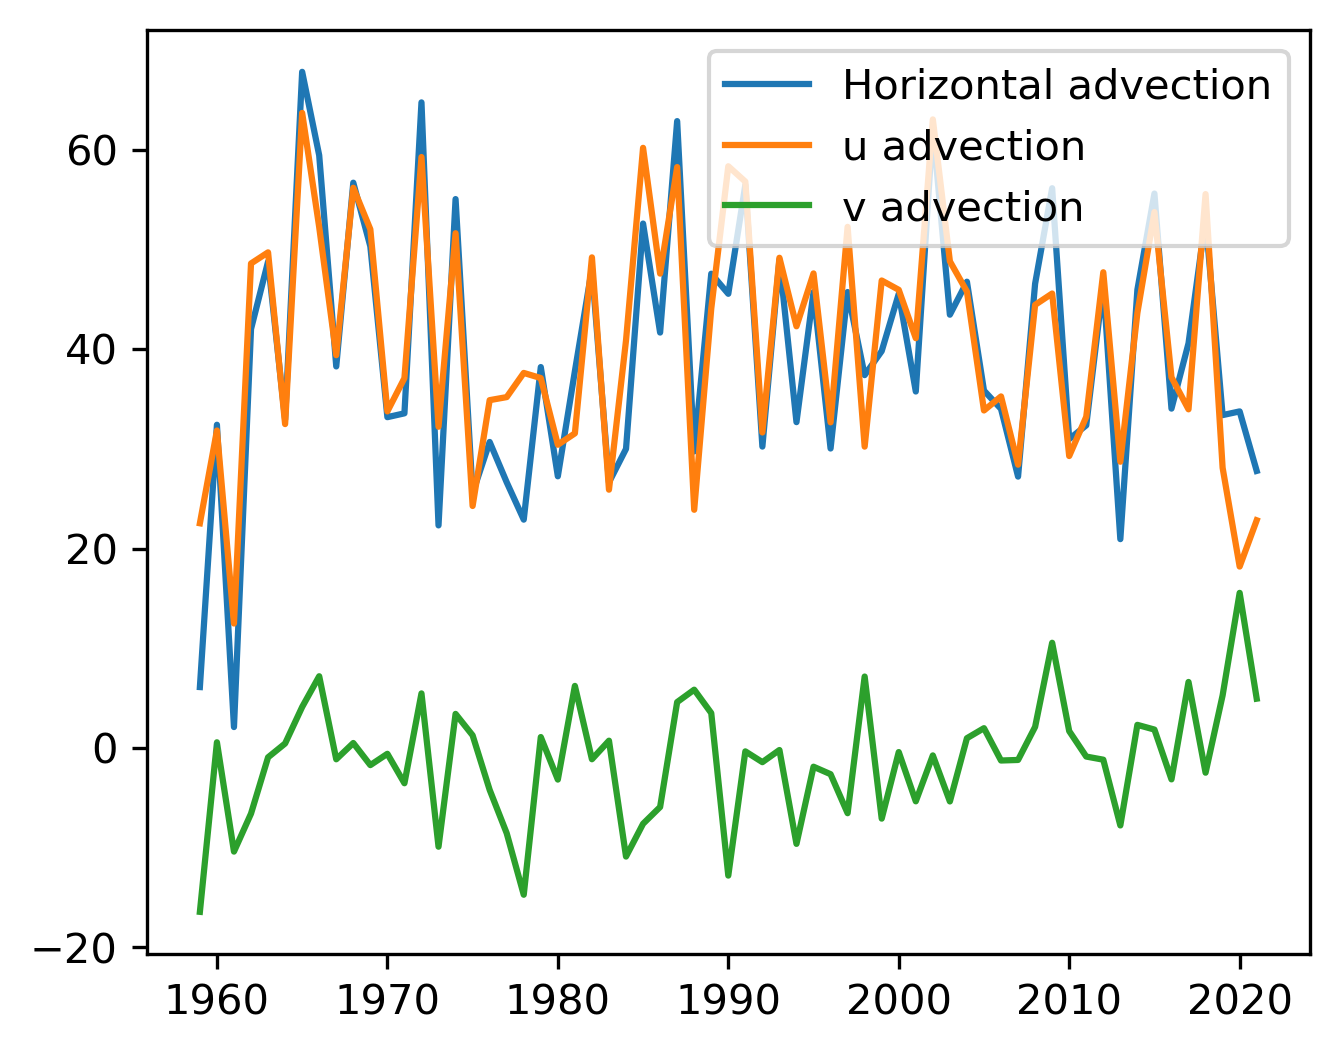

In [10]:
plt.rcParams['figure.figsize'] = [5,4]
plt.plot(X, hadvind, label='Horizontal advection')
plt.plot(X, uadvind, label='u advection')
plt.plot(X, vadvind, label='v advection')
plt.legend()

In [11]:
#For Bob
x=ds5.level
xs= np.arange(1, 1001, 1)
wadvbob=[]
hadvbob=[]
for j in ds5.year:
    ds6 = ds5.sel(year=j)
    ps2 = ds13.sel(year=j)
    m = Cp*ds6.t + Lv*ds6.q + ds6.z
    wadv = mpcalc.advection(m, w=ds6.w)
    inter = wadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps2)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    wadvbob.append(-1*integral.mean(dim=['latitude', 'longitude']))
    hadv = mpcalc.advection(m, u=ds6.u, v=ds6.v)
    inter = hadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps2)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    hadvbob.append(-100*integral.mean(dim=['latitude', 'longitude']))

Text(0.5, 0.98, 'JJAS averages, ERA5')

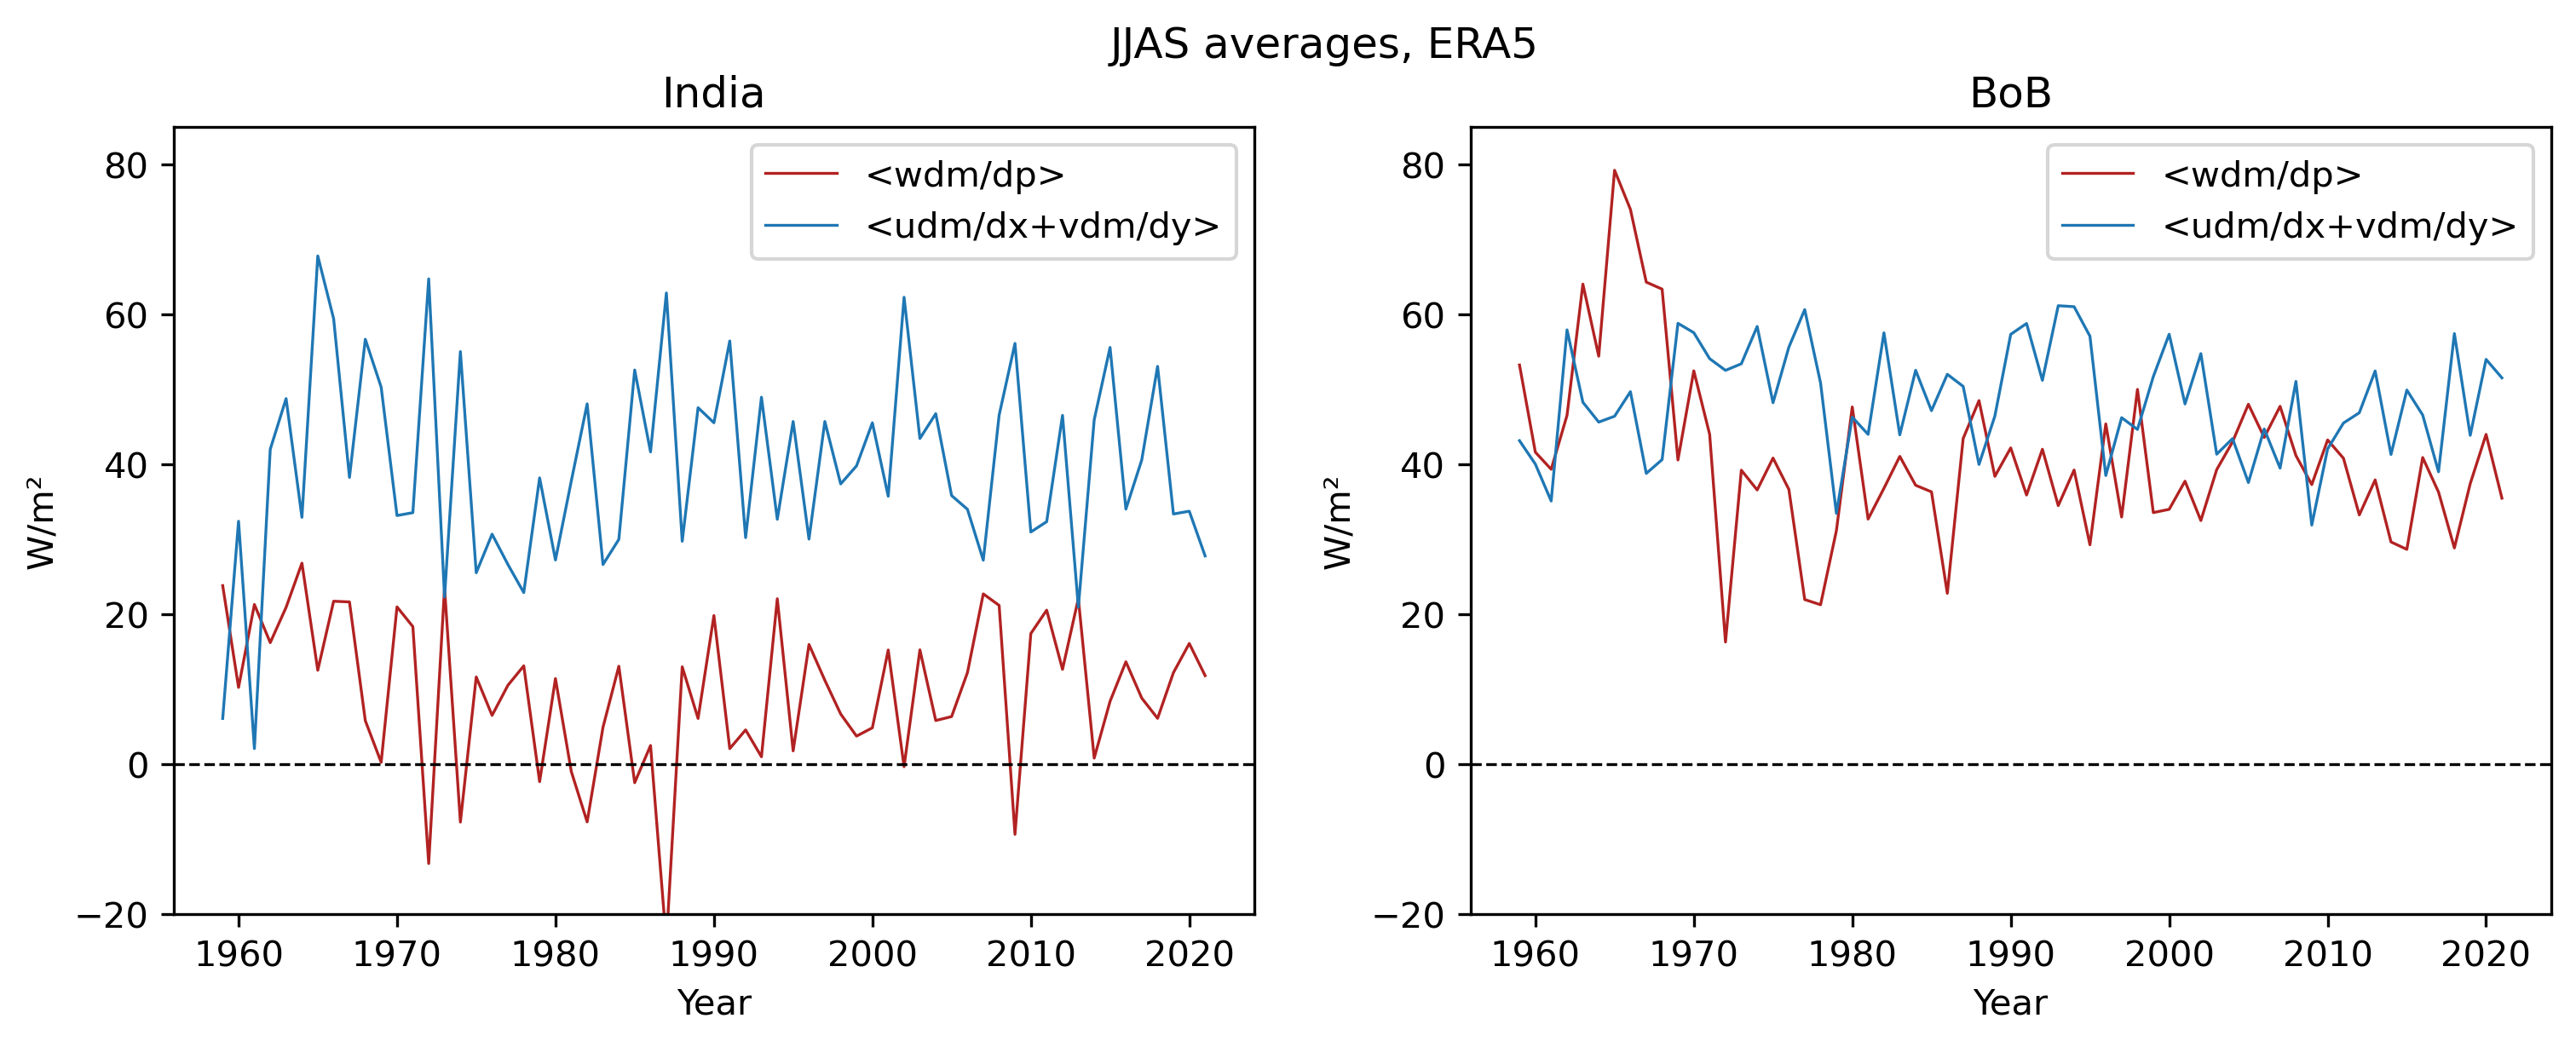

In [12]:
plt.rcParams['figure.figsize'] = [12,4]
plt.subplot(1,2,1)
plt.plot(ds5.year, wadvind, c='firebrick', label='<wdm/dp>', linewidth=0.8)
plt.plot(ds5.year, hadvind, label='<udm/dx+vdm/dy>', linewidth=0.8)
plt.xlabel('Year')
plt.ylabel('W/m\u00b2')
plt.ylim(-20,85)
plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth=0.8)
plt.legend()
plt.title('India')

plt.subplot(1,2,2)
plt.plot(ds5.year, wadvbob, c='firebrick', label='<wdm/dp>', linewidth=0.8)
plt.plot(ds5.year, hadvbob, label='<udm/dx+vdm/dy>', linewidth=0.8)
plt.xlabel('Year')
plt.ylabel('W/m\u00b2')
plt.ylim(-20,85)
plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth=0.8)
plt.legend()
plt.title('BoB')

plt.suptitle('JJAS averages, ERA5')

In [22]:
h = '/media/rakshith/Seagate Expansion Drive/mraks/TGMS ERA 1959-2021, India only.nc'
#h = '/media/rakshith/Windows/Users/mraks/TGMS ERA 1959-2021, India only.nc'
ds = xr.open_dataset(h)

lon_grid, lat_grid = np.meshgrid(ds.longitude, ds.latitude)
mask = globe.is_land(lat_grid, lon_grid)

jjas = ds.time.dt.month.isin(range(6, 10)) #JJAS
clim = ds.sel(time=jjas)
clim = clim.groupby('time.year').mean('time')
clim3 = clim.where(mask>0).mean(dim=['latitude', 'longitude'])
Qnet = clim3.mtnswrf + clim3.mtnlwrf

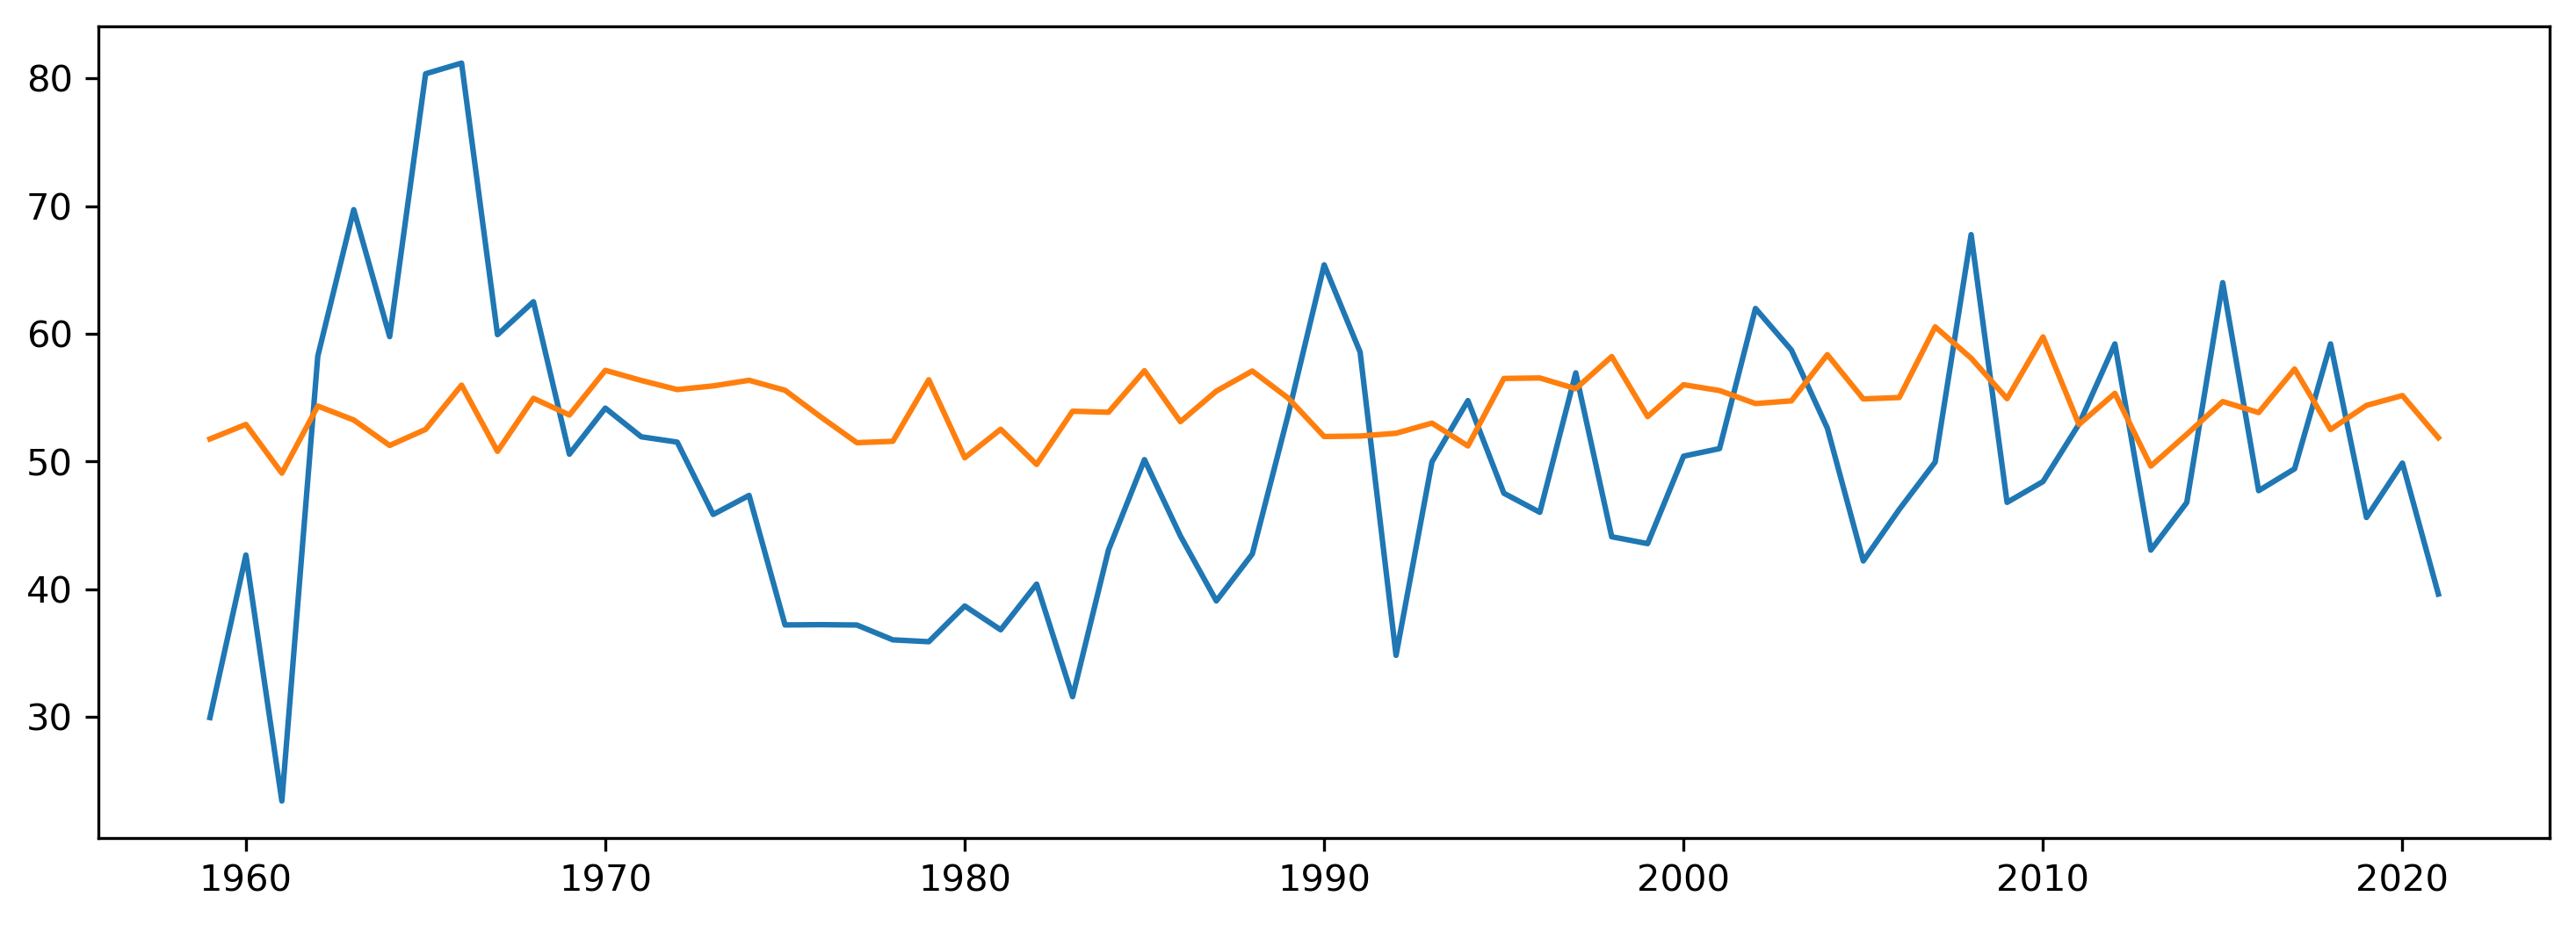

In [23]:
plt.plot(ds5.year, np.add(wadvind, hadvind))
plt.plot(ds5.year, Qnet)

In [13]:
#q advection terms
x=ds7.level
xs= np.arange(1, 1001, 1)
qhadvind=[] #horizontal advection
qwadvind=[] #vertical advection
for j in ds7.year:
    ds8 = ds7.sel(year=j)
    ps1 = ds11.sel(year=j)
    q = ds8.q
    wadv = mpcalc.advection(q, w=ds8.w)
    inter = wadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    qwadvind.append(integral.where(mask1>0).mean(dim=['latitude', 'longitude']))
    hadv = mpcalc.advection(q, u=ds8.u, v=ds8.v)
    inter = hadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    qhadvind.append(100*integral.where(mask1>0).mean(dim=['latitude', 'longitude']))

In [14]:
#For Bob
x=ds5.level
xs= np.arange(1, 1001, 1)
qwadvbob=[]
qhadvbob=[]

for j in ds5.year:
    ds6 = ds5.sel(year=j)
    ps2 = ds13.sel(year=j)
    q = ds6.q
    wadv = mpcalc.advection(q, w=ds6.w)
    inter = wadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps2)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    qwadvbob.append(integral.mean(dim=['latitude', 'longitude']))
    hadv = mpcalc.advection(q, u=ds6.u, v=ds6.v)
    inter = hadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps2)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    qhadvbob.append(100*integral.mean(dim=['latitude', 'longitude']))

Text(0.5, 0.98, 'JJAS averages, ERA5')

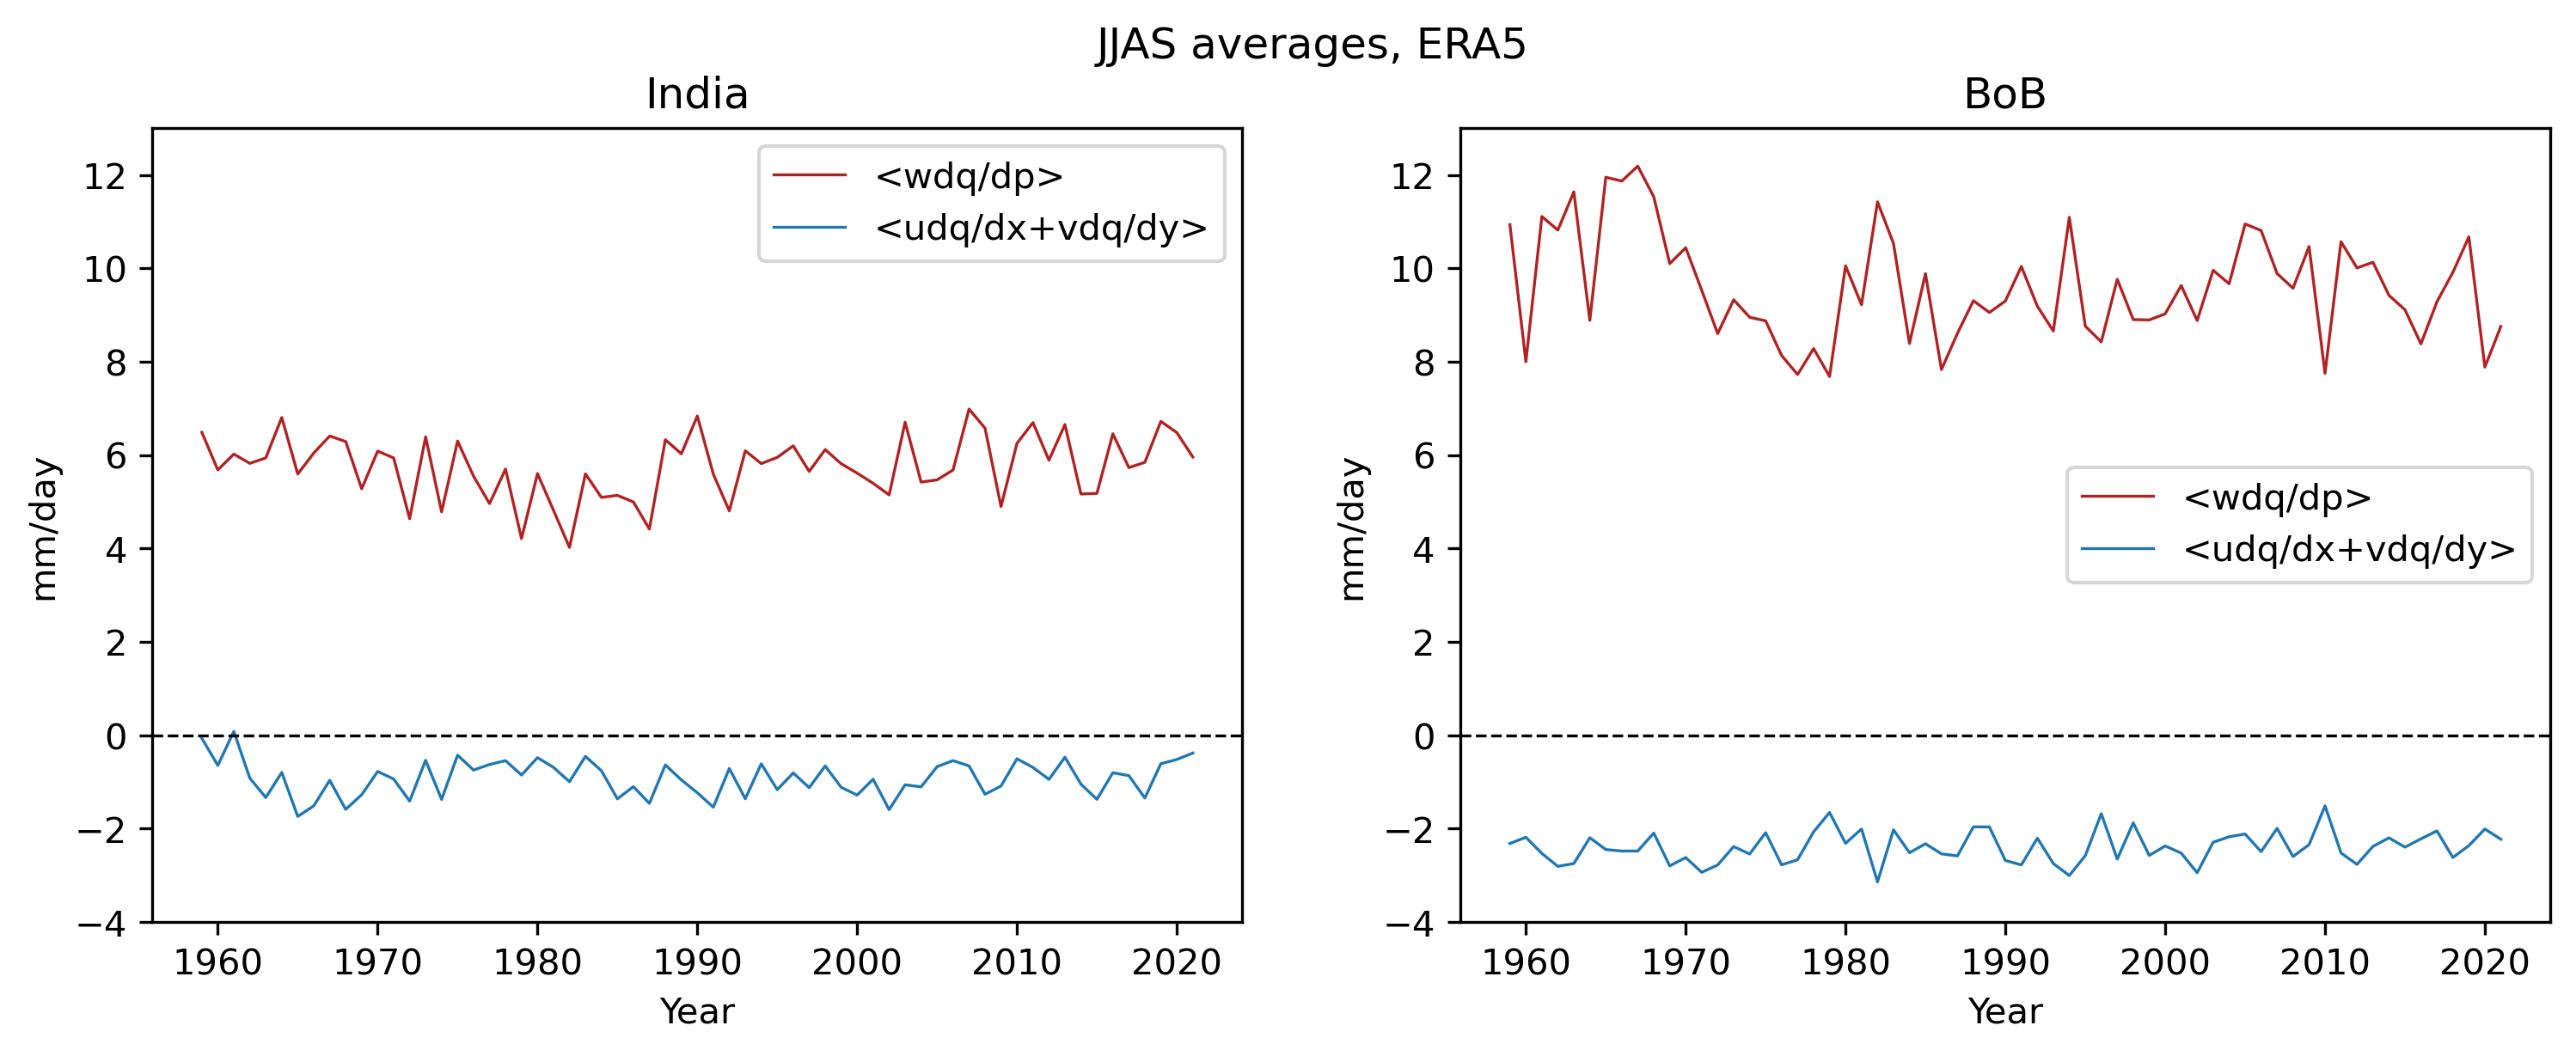

In [15]:
plt.rcParams['figure.figsize'] = [12,4]
plt.subplot(1,2,1)
plt.plot(ds5.year, np.multiply(86400, qwadvind), c='firebrick', label='<wdq/dp>', linewidth=0.8)
plt.plot(ds5.year, np.multiply(86400, qhadvind), label='<udq/dx+vdq/dy>', linewidth=0.8)
plt.xlabel('Year')
plt.ylabel('mm/day')
plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth=0.8)
plt.ylim(-4,13)
plt.legend()
plt.title('India')

plt.subplot(1,2,2)
plt.plot(ds5.year, np.multiply(86400, qwadvbob), c='firebrick', label='<wdq/dp>', linewidth=0.8)
plt.plot(ds5.year, np.multiply(86400, qhadvbob), label='<udq/dx+vdq/dy>', linewidth=0.8)
plt.xlabel('Year')
plt.ylabel('mm/day')
plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth=0.8)
plt.ylim(-4,13)
plt.legend()
plt.title('BoB')

plt.suptitle('JJAS averages, ERA5')

In [16]:
Pwatind = np.array([49.666298, 49.211952, 50.84885 , 48.112865, 48.8205  , 49.776905,
       45.184708, 48.423508, 49.205353, 47.53274 , 47.167625, 50.244846,
       47.788998, 44.300728, 50.16431 , 45.51019 , 49.21662 , 46.48348 ,
       47.8133  , 48.712677, 45.274555, 49.731056, 47.935646, 45.61624 ,
       49.90188 , 46.815468, 46.608387, 45.621265, 45.90031 , 50.86714 ,
       48.681293, 51.16373 , 48.66296 , 45.784225, 48.623173, 49.56115 ,
       48.213364, 49.256355, 48.546535, 51.16784 , 48.480495, 47.677162,
       48.605286, 46.661377, 50.586395, 47.48501 , 48.14316 , 49.01584 ,
       51.482563, 50.217396, 47.368294, 51.486343, 51.314983, 49.896988,
       51.854214, 48.430523, 48.60528 , 51.786613, 51.660336, 50.409145,
       52.155293, 53.491444, 52.18347 ])

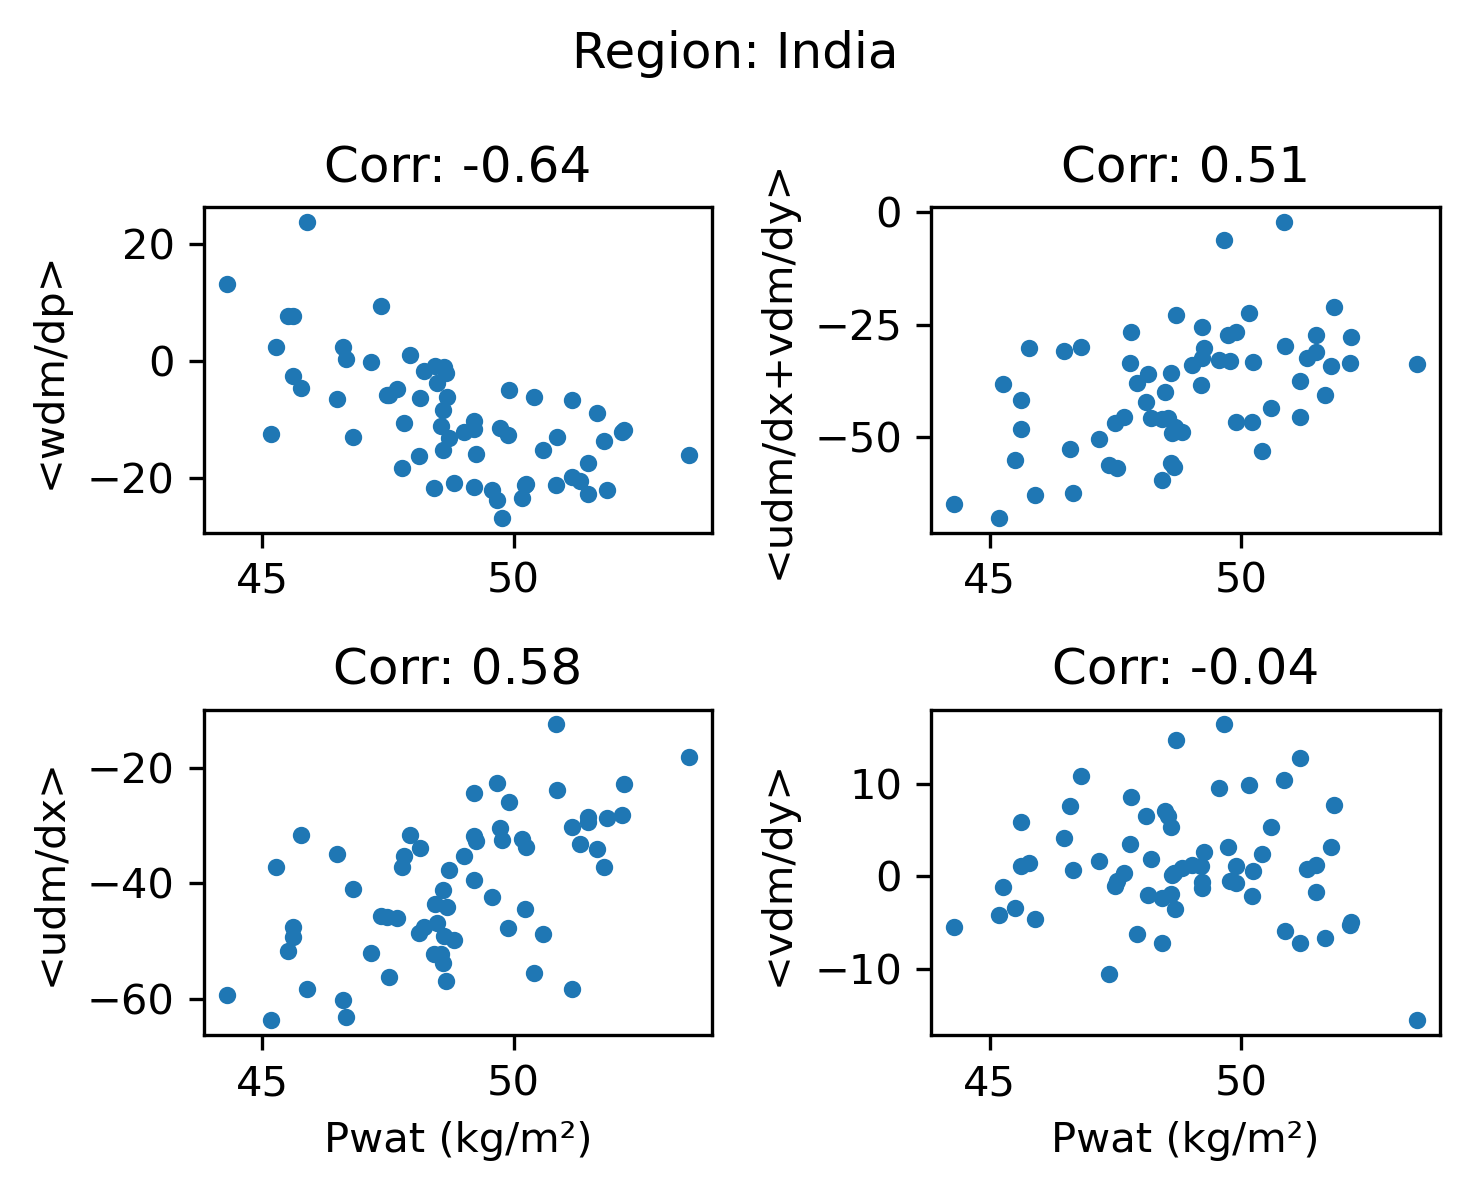

In [17]:
corr1 = np.corrcoef(Pwatind, np.multiply(-1, wadvind))[0][1]
corr2 = np.corrcoef(Pwatind, np.multiply(-1, hadvind))[0][1]
corr3 = np.corrcoef(Pwatind, np.multiply(-1, uadvind))[0][1]
corr4 = np.corrcoef(Pwatind, np.multiply(-1, vadvind))[0][1]

plt.rcParams['figure.figsize'] = [5,4]
plt.subplot(2,2,1)
plt.scatter(Pwatind, np.multiply(-1, wadvind), s=10)
plt.ylabel('<wdm/dp>')
plt.title('Corr: %.2f' %corr1)

plt.subplot(2,2,2)
plt.scatter(Pwatind, np.multiply(-1, hadvind), s=10)
plt.ylabel('<udm/dx+vdm/dy>')
plt.title('Corr: %.2f' %corr2)

plt.subplot(2,2,3)
plt.scatter(Pwatind, np.multiply(-1, uadvind), s=10)
plt.xlabel('Pwat (kg/m\u00b2)')
plt.ylabel('<udm/dx>')
plt.title('Corr: %.2f' %corr3)

plt.subplot(2,2,4)
plt.scatter(Pwatind, np.multiply(-1, vadvind), s=10)
plt.xlabel('Pwat (kg/m\u00b2)')
plt.ylabel('<vdm/dy>')
plt.title('Corr: %.2f' %corr4)

plt.suptitle('Region: India')
plt.tight_layout()

In [18]:
TGMSint = np.divide(np.add(wadvind,hadvind), 86400*28.96*np.add(qwadvind,qhadvind))
TGMSqdiv = np.array([0.31993425, 0.3918915 , 0.31908637, 0.39466286, 0.385008  ,
       0.29494342, 0.41601253, 0.40001655, 0.3130415 , 0.39064518,
       0.49851742, 0.38792467, 0.4085231 , 0.6148284 , 0.36711162,
       0.6331631 , 0.36151084, 0.4506404 , 0.52760273, 0.42405674,
       0.7495344 , 0.38281608, 0.51806575, 0.63326305, 0.41317156,
       0.4740755 , 0.6058769 , 0.53100073, 0.85711396, 0.39183652,
       0.41488746, 0.33186743, 0.45410803, 0.5518247 , 0.43891224,
       0.35591692, 0.50259966, 0.4251953 , 0.4508301 , 0.46891022,
       0.4672668 , 0.5004703 , 0.5021225 , 0.56653357, 0.36019275,
       0.54251474, 0.4605775 , 0.4307667 , 0.36306304, 0.37312472,
       0.5018262 , 0.3820654 , 0.31356087, 0.4056416 , 0.29944292,
       0.47037366, 0.5144901 , 0.33984637, 0.43084288, 0.39368454,
       0.3183021 , 0.3536784 , 0.3837112 ])
TGMSerror = TGMSqdiv-TGMSint

In [26]:
TGMSapprox = np.divide(wadvind, 86400*28.96*np.array(qwadvind))

In [21]:
u850 = ds7.u.sel(level=850).where(mask1>0).mean(dim=['latitude', 'longitude'])
v850 = ds7.v.sel(level=850).where(mask1>0).mean(dim=['latitude', 'longitude'])

Text(0.5, 1.0, 'Corr: 0.65')

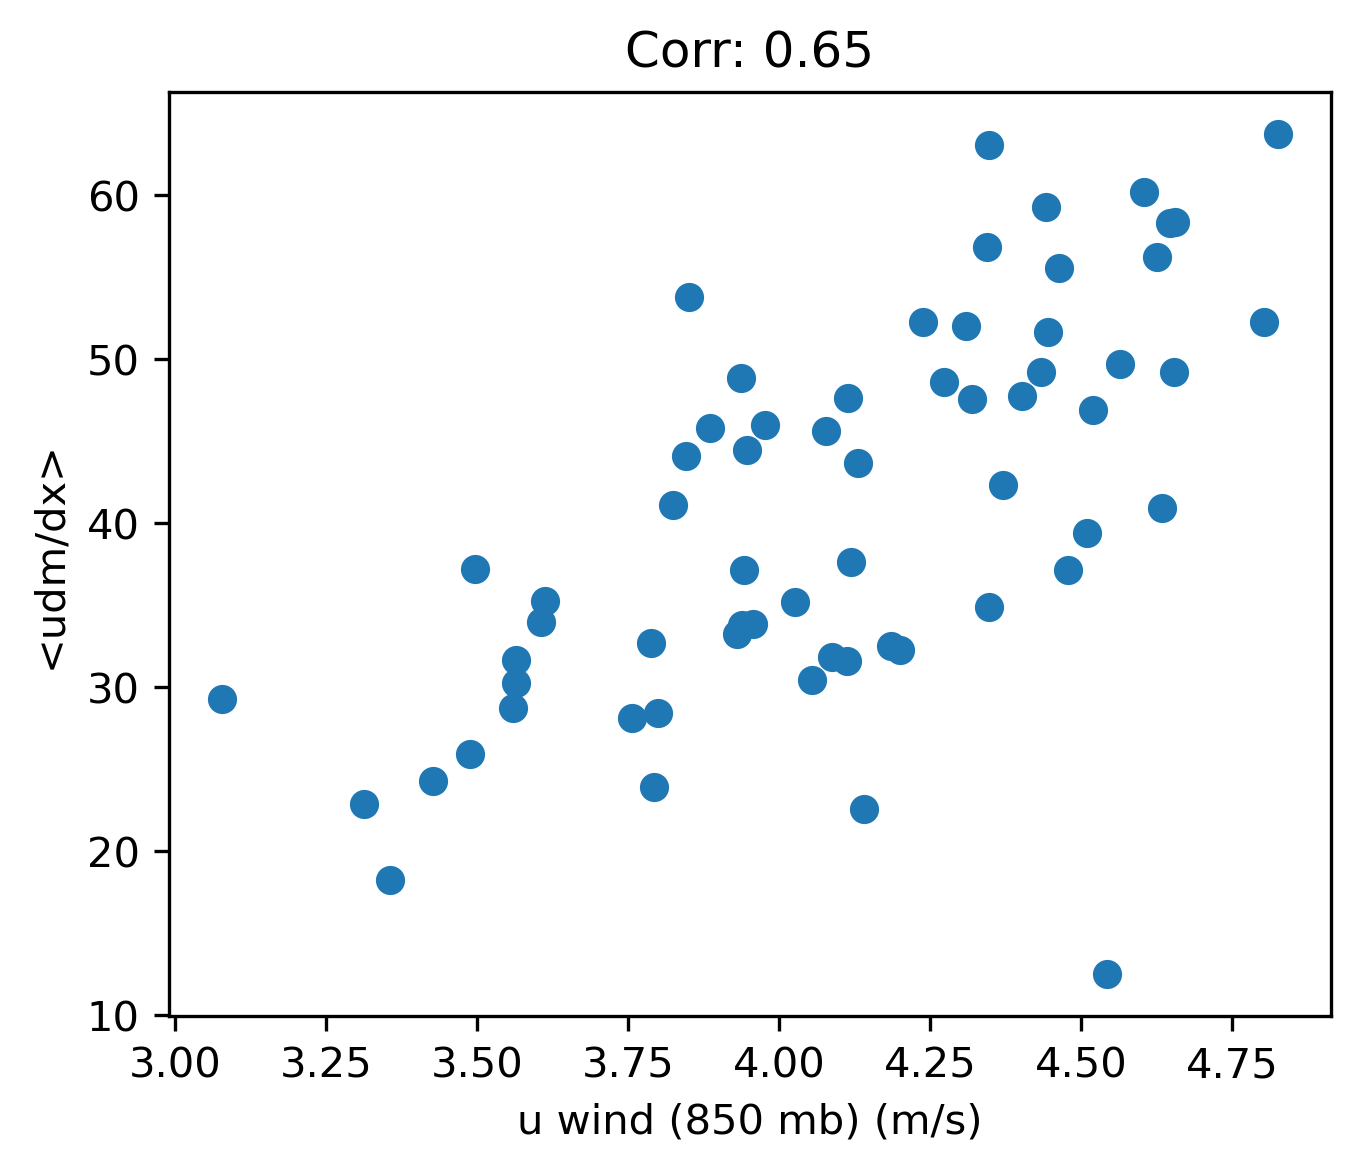

In [69]:
plt.scatter(u850, np.multiply(-1, uadvind))
plt.xlabel('u wind (850 mb) (m/s)')
plt.ylabel('<udm/dx>')
plt.title('Corr: %.2f' %np.corrcoef(u850, np.multiply(-1, umadvind))[0][1])

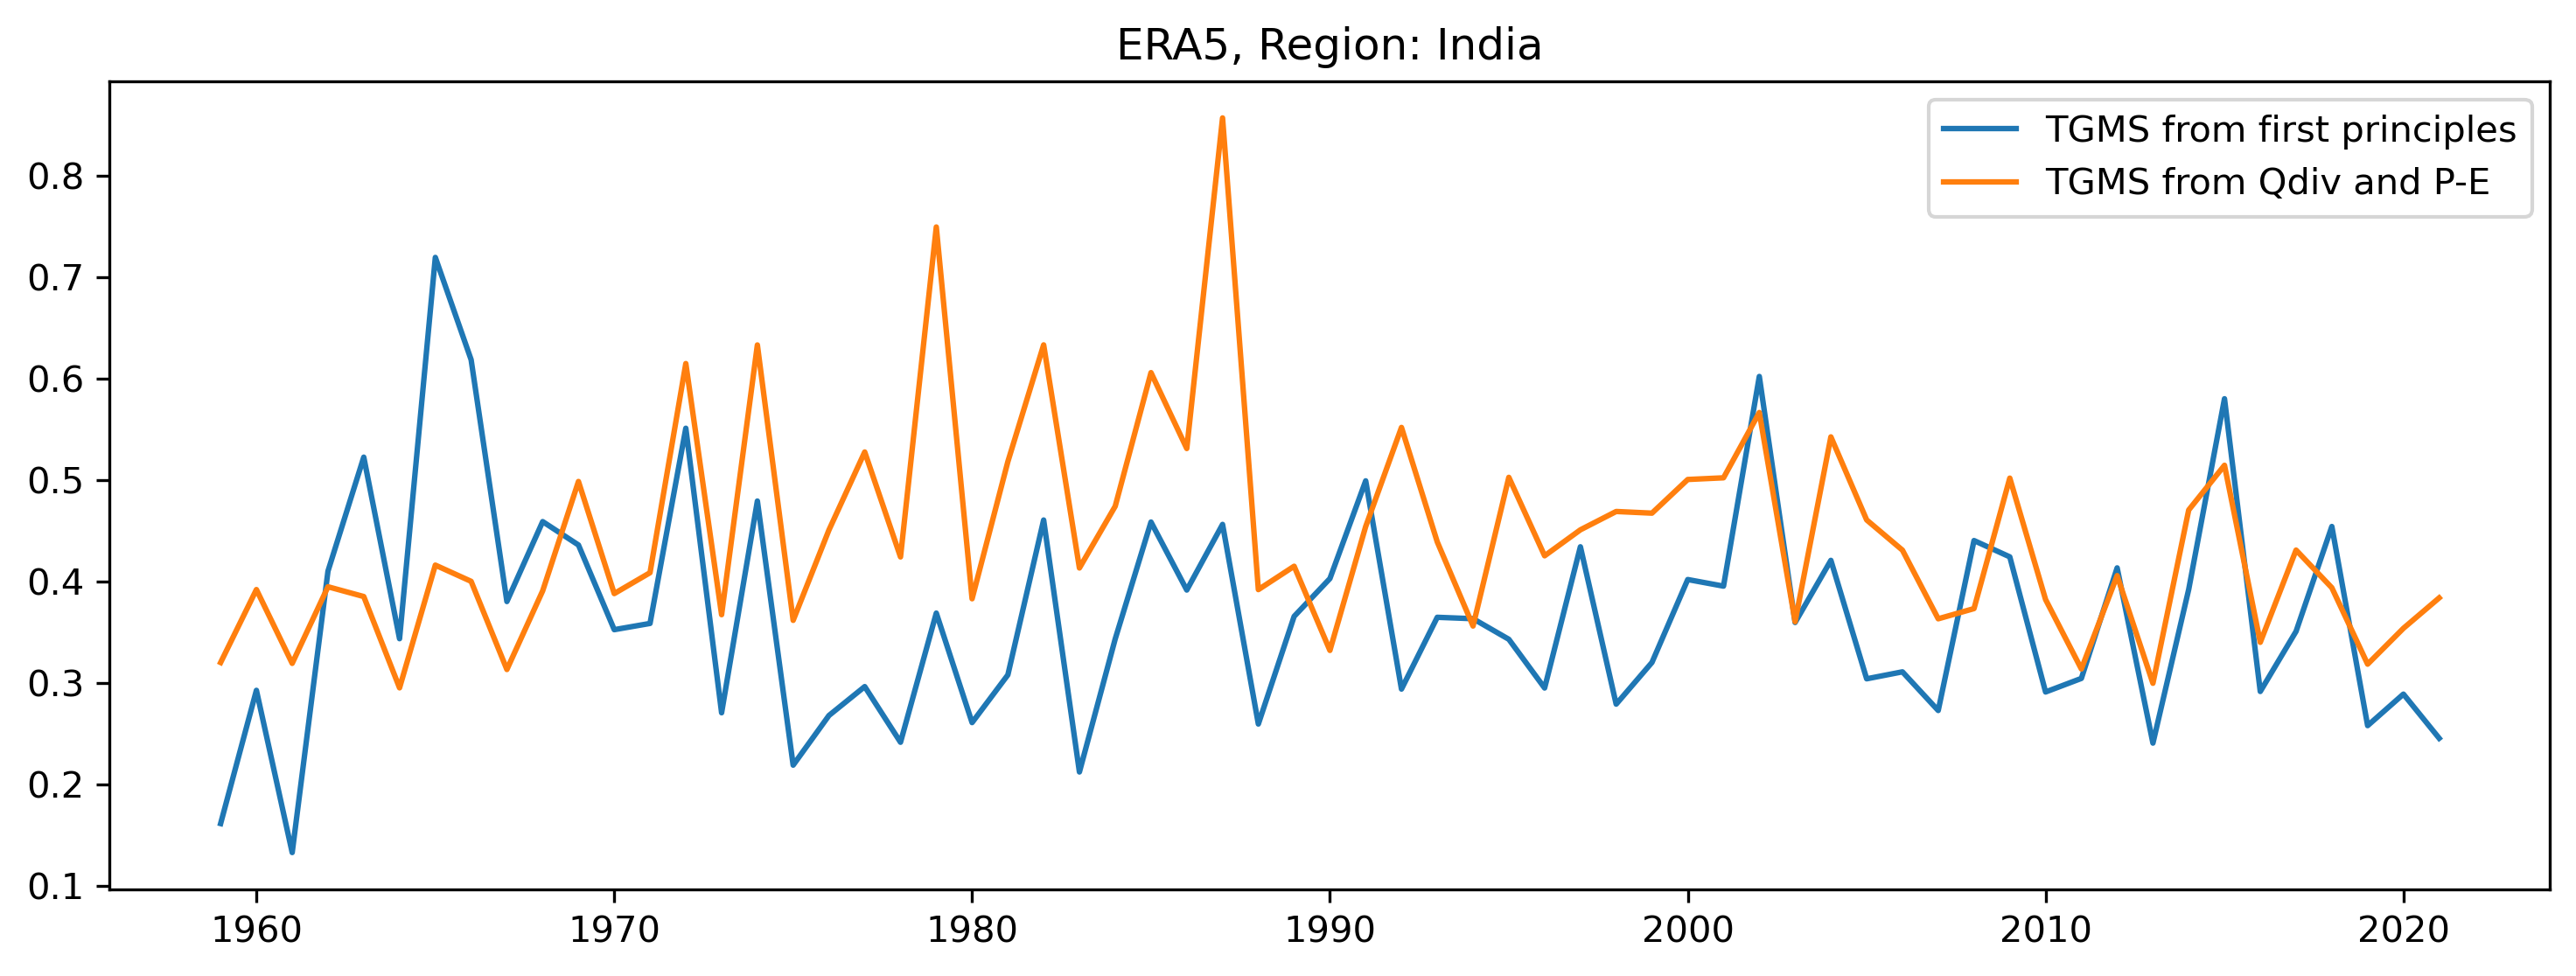

In [28]:
plt.plot(X, TGMSint, label='TGMS from first principles')
plt.plot(X, TGMSqdiv, label='TGMS from Qdiv and P-E')
#plt.plot(X, TGMSapprox, label='TGMS without horizontal advection terms')
plt.title('ERA5, Region: India')
plt.legend()

In [24]:
indavg = ds7.where(mask1>0).mean(dim=['latitude', 'longitude'])

In [25]:
M = Cp*indavg.t+Lv*indavg.q+indavg.z

In [26]:
VMS =  M.sel(level=200)-M.sel(level=850)

In [27]:
m850 = M.sel(level=850)

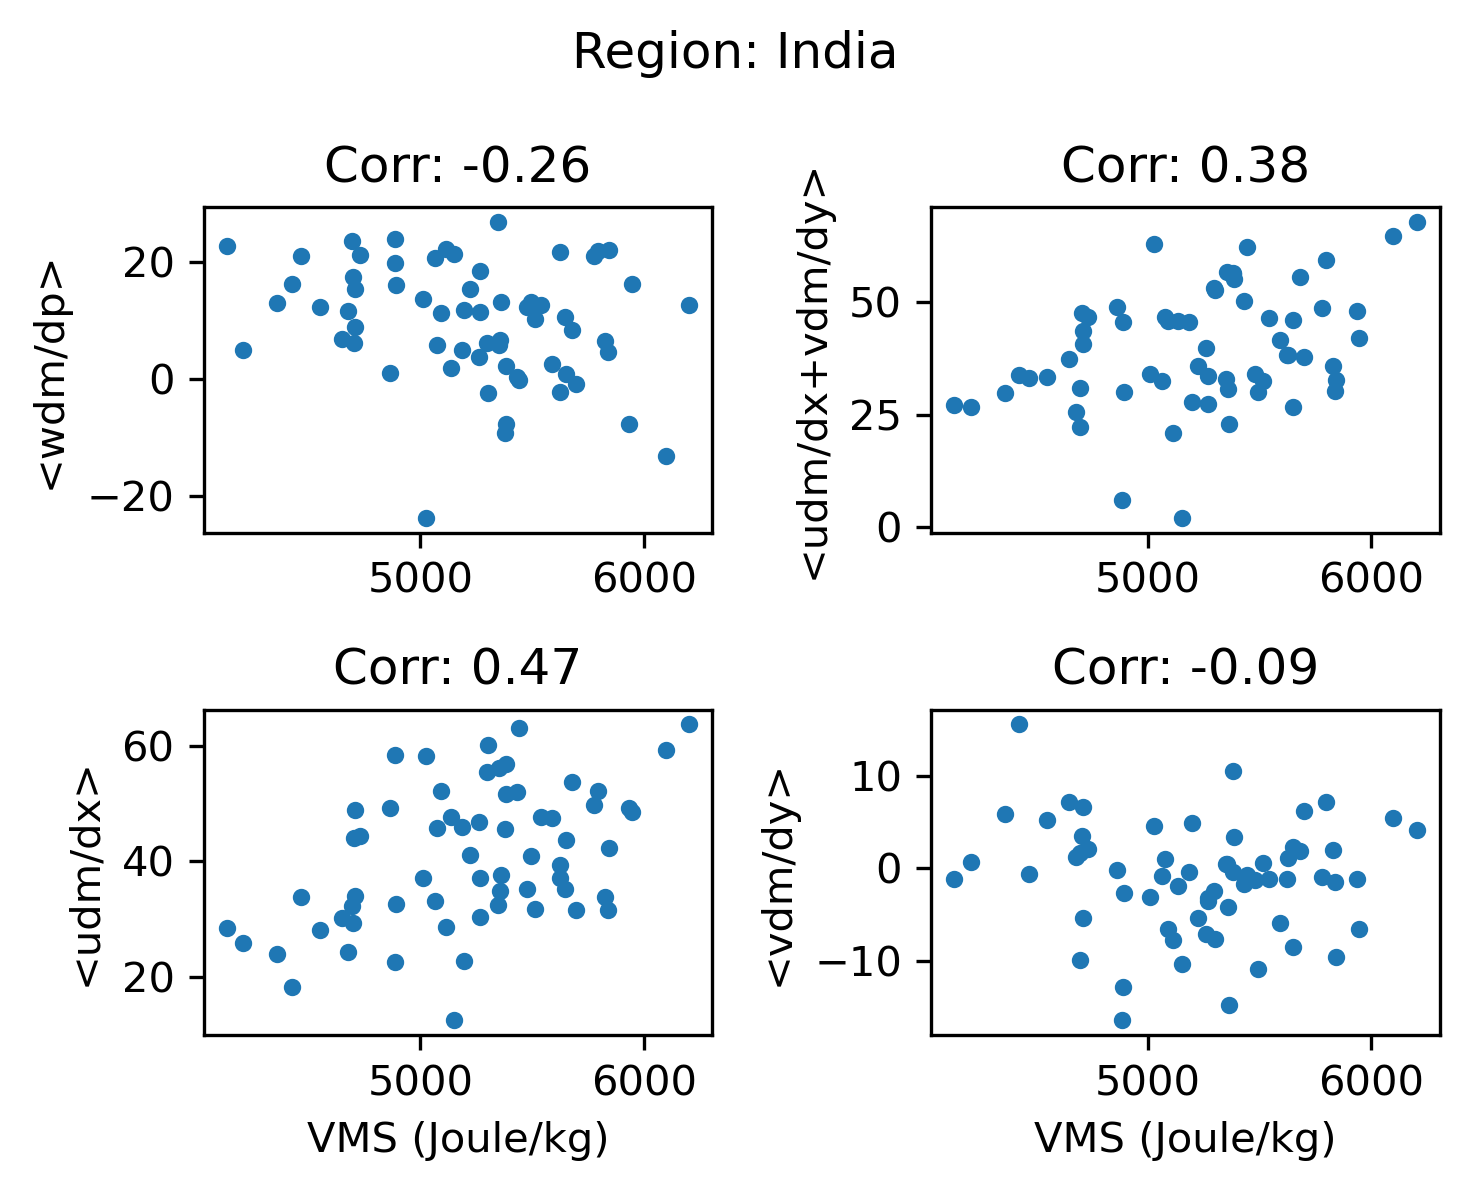

In [70]:
corr1 = np.corrcoef(VMS, np.multiply(-1, wadvind))[0][1]
corr2 = np.corrcoef(VMS, np.multiply(-1, hadvind))[0][1]
corr3 = np.corrcoef(VMS, np.multiply(-1, uadvind))[0][1]
corr4 = np.corrcoef(VMS, np.multiply(-1, vadvind))[0][1]

plt.rcParams['figure.figsize'] = [5,4]
plt.subplot(2,2,1)
plt.scatter(VMS, np.multiply(-1, wadvind), s=10)
plt.ylabel('<wdm/dp>')
plt.title('Corr: %.2f' %corr1)

plt.subplot(2,2,2)
plt.scatter(VMS, np.multiply(-1, hadvind), s=10)
plt.ylabel('<udm/dx+vdm/dy>')
plt.title('Corr: %.2f' %corr2)

plt.subplot(2,2,3)
plt.scatter(VMS, np.multiply(-1, uadvind), s=10)
plt.xlabel('VMS (Joule/kg)')
plt.ylabel('<udm/dx>')
plt.title('Corr: %.2f' %corr3)

plt.subplot(2,2,4)
plt.scatter(VMS, np.multiply(-1, vadvind), s=10)
plt.xlabel('VMS (Joule/kg)')
plt.ylabel('<vdm/dy>')
plt.title('Corr: %.2f' %corr4)

plt.suptitle('Region: India')
plt.tight_layout()

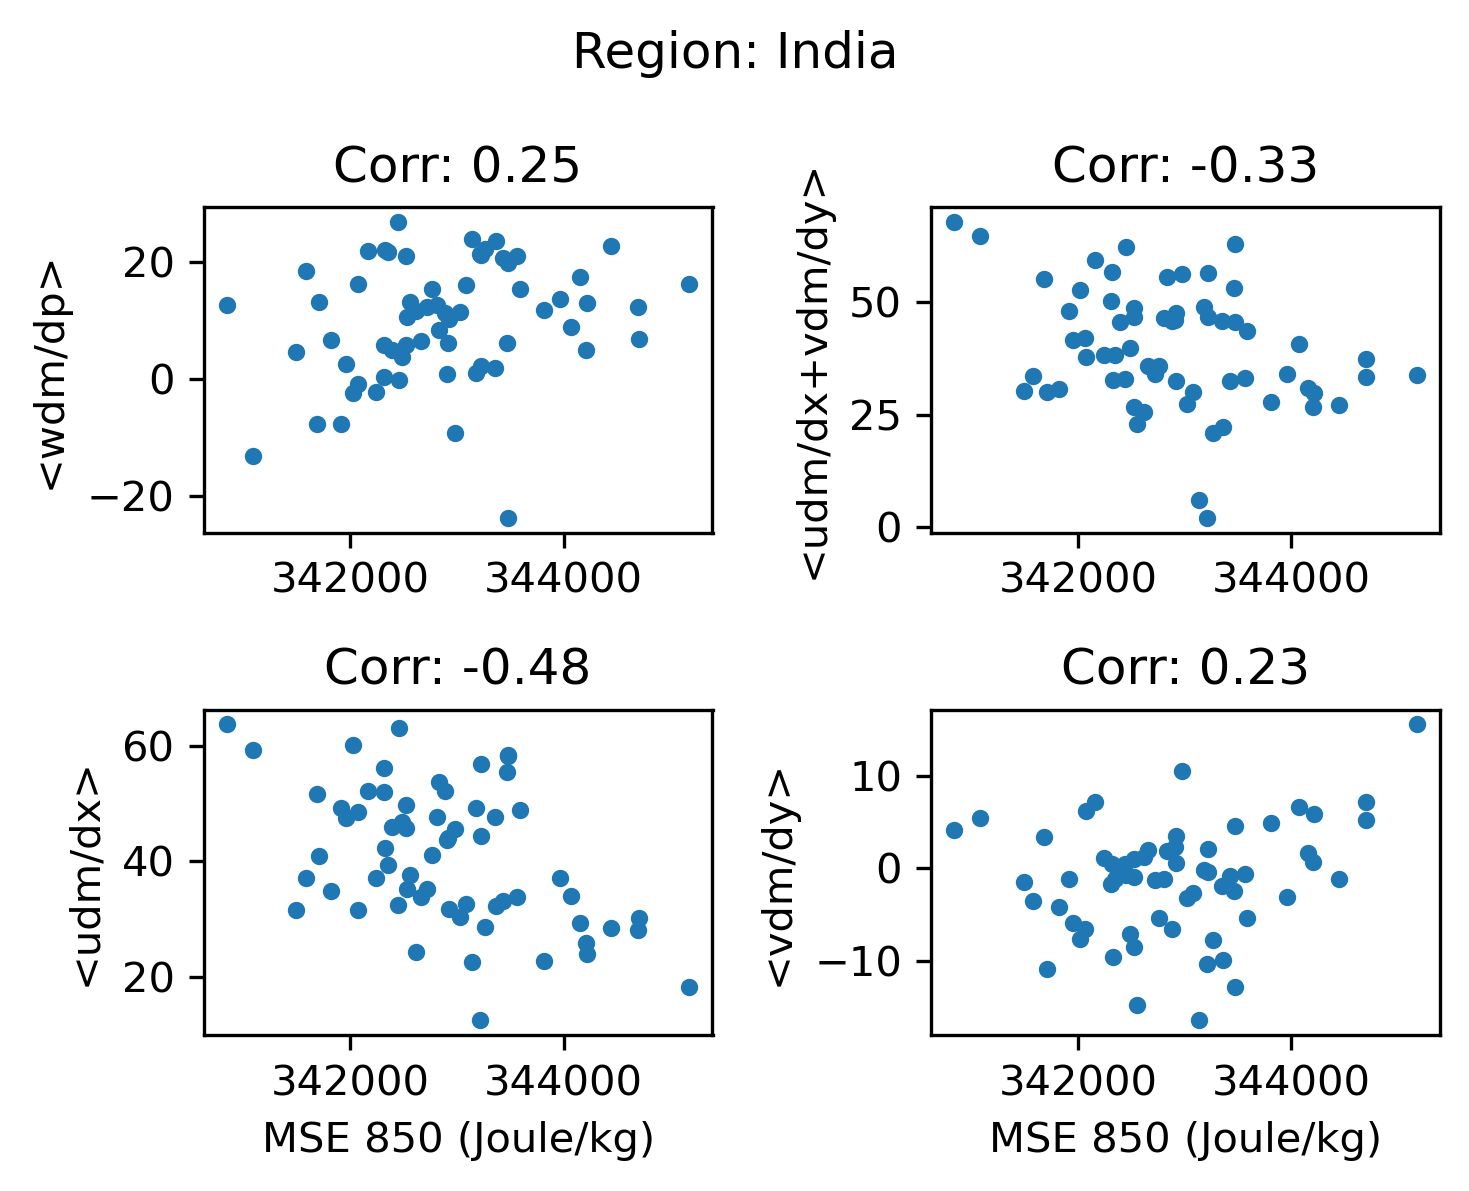

In [71]:
corr1 = np.corrcoef(m850, np.multiply(-1, wadvind))[0][1]
corr2 = np.corrcoef(m850, np.multiply(-1, hadvind))[0][1]
corr3 = np.corrcoef(m850, np.multiply(-1, uadvind))[0][1]
corr4 = np.corrcoef(m850, np.multiply(-1, vadvind))[0][1]

plt.rcParams['figure.figsize'] = [5,4]
plt.subplot(2,2,1)
plt.scatter(m850, np.multiply(-1, wadvind), s=10)
plt.ylabel('<wdm/dp>')
plt.title('Corr: %.2f' %corr1)

plt.subplot(2,2,2)
plt.scatter(m850, np.multiply(-1, hadvind), s=10)
plt.ylabel('<udm/dx+vdm/dy>')
plt.title('Corr: %.2f' %corr2)

plt.subplot(2,2,3)
plt.scatter(m850, np.multiply(-1, uadvind), s=10)
plt.xlabel('MSE 850 (Joule/kg)')
plt.ylabel('<udm/dx>')
plt.title('Corr: %.2f' %corr3)

plt.subplot(2,2,4)
plt.scatter(m850, np.multiply(-1, vadvind), s=10)
plt.xlabel('MSE 850 (Joule/kg)')
plt.ylabel('<vdm/dy>')
plt.title('Corr: %.2f' %corr4)

plt.suptitle('Region: India')
plt.tight_layout()

In [34]:
bobavg = ds5.mean(dim=['latitude', 'longitude'])

In [35]:
M1 = Cp*bobavg.t+Lv*bobavg.q+bobavg.z

In [36]:
delm = M.mean(dim='level')-M1.mean(dim='level')

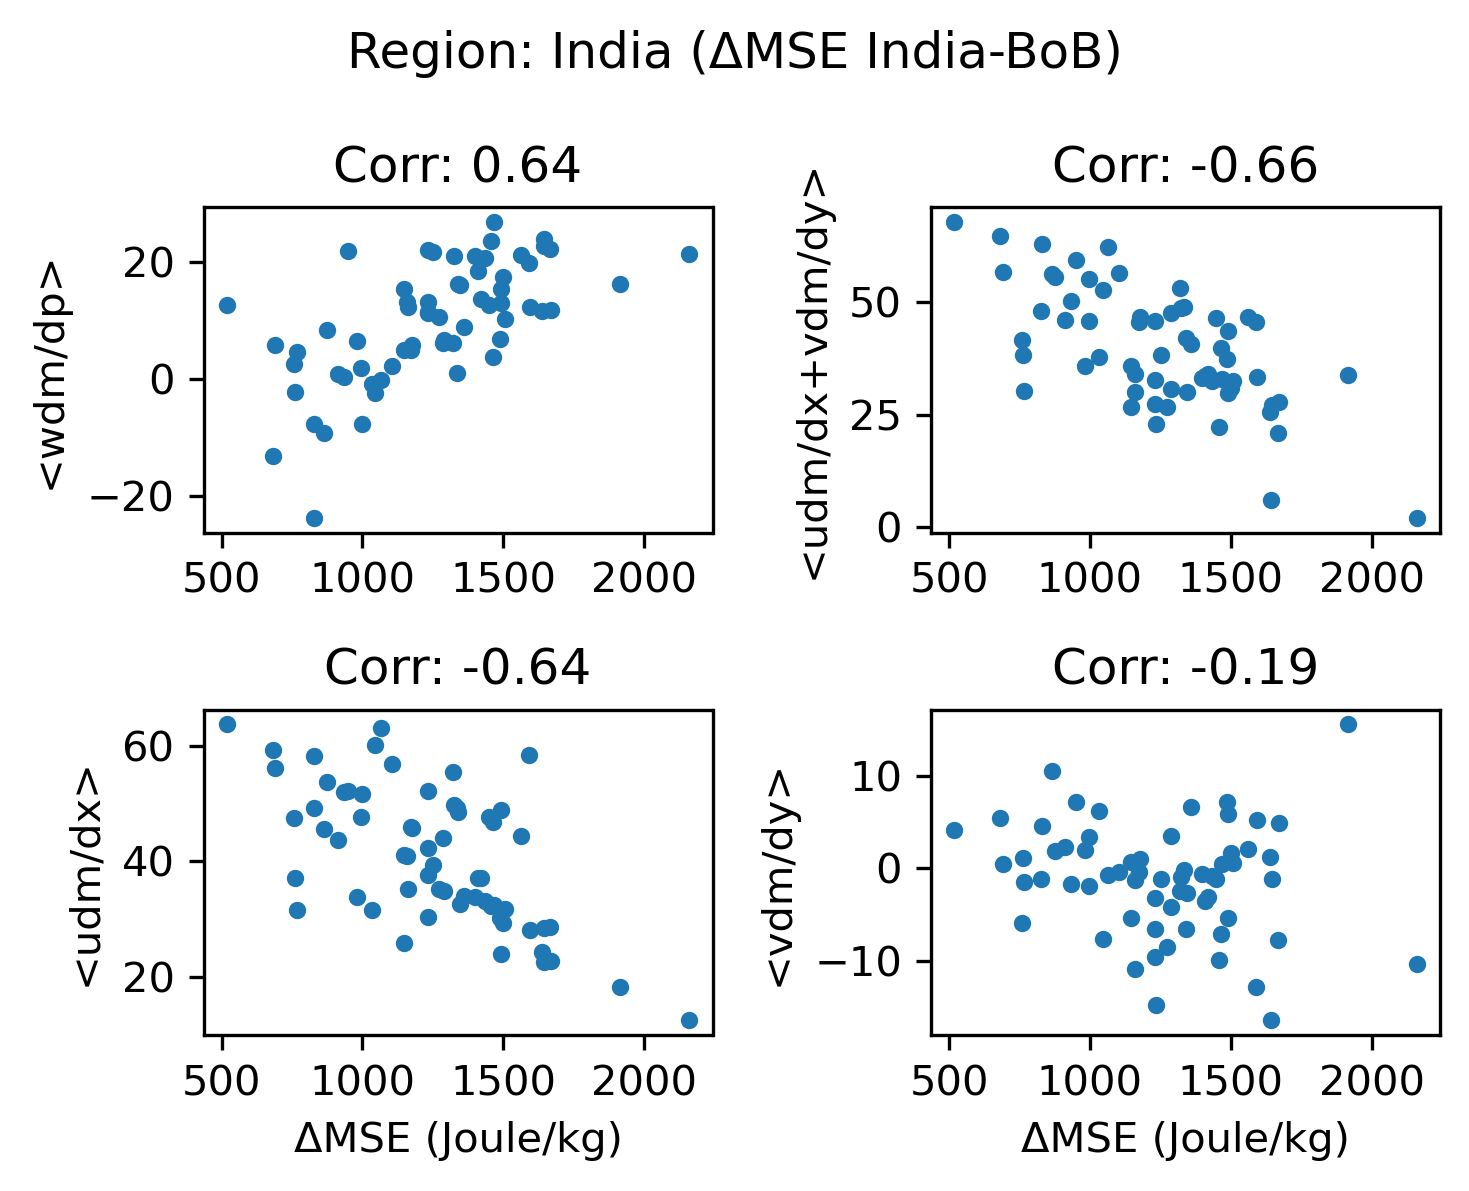

In [72]:
corr1 = np.corrcoef(delm, np.multiply(-1, wadvind))[0][1]
corr2 = np.corrcoef(delm, np.multiply(-1, hadvind))[0][1]
corr3 = np.corrcoef(delm, np.multiply(-1, uadvind))[0][1]
corr4 = np.corrcoef(delm, np.multiply(-1, vadvind))[0][1]

plt.rcParams['figure.figsize'] = [5,4]
plt.subplot(2,2,1)
plt.scatter(delm, np.multiply(-1, wadvind), s=10)
plt.ylabel('<wdm/dp>')
plt.title('Corr: %.2f' %corr1)


plt.subplot(2,2,2)
plt.scatter(delm, np.multiply(-1, hadvind), s=10)
plt.ylabel('<udm/dx+vdm/dy>')
plt.title('Corr: %.2f' %corr2)

plt.subplot(2,2,3)
plt.scatter(delm, np.multiply(-1, uadvind), s=10)
plt.xlabel('\u0394MSE (Joule/kg)')
plt.ylabel('<udm/dx>')
plt.title('Corr: %.2f' %corr3)

plt.subplot(2,2,4)
plt.scatter(delm, np.multiply(-1, vadvind), s=10)
plt.xlabel('\u0394MSE (Joule/kg)')
plt.ylabel('<vdm/dy>')
plt.title('Corr: %.2f' %corr4)

plt.suptitle('Region: India (\u0394MSE India-BoB)')
plt.tight_layout()

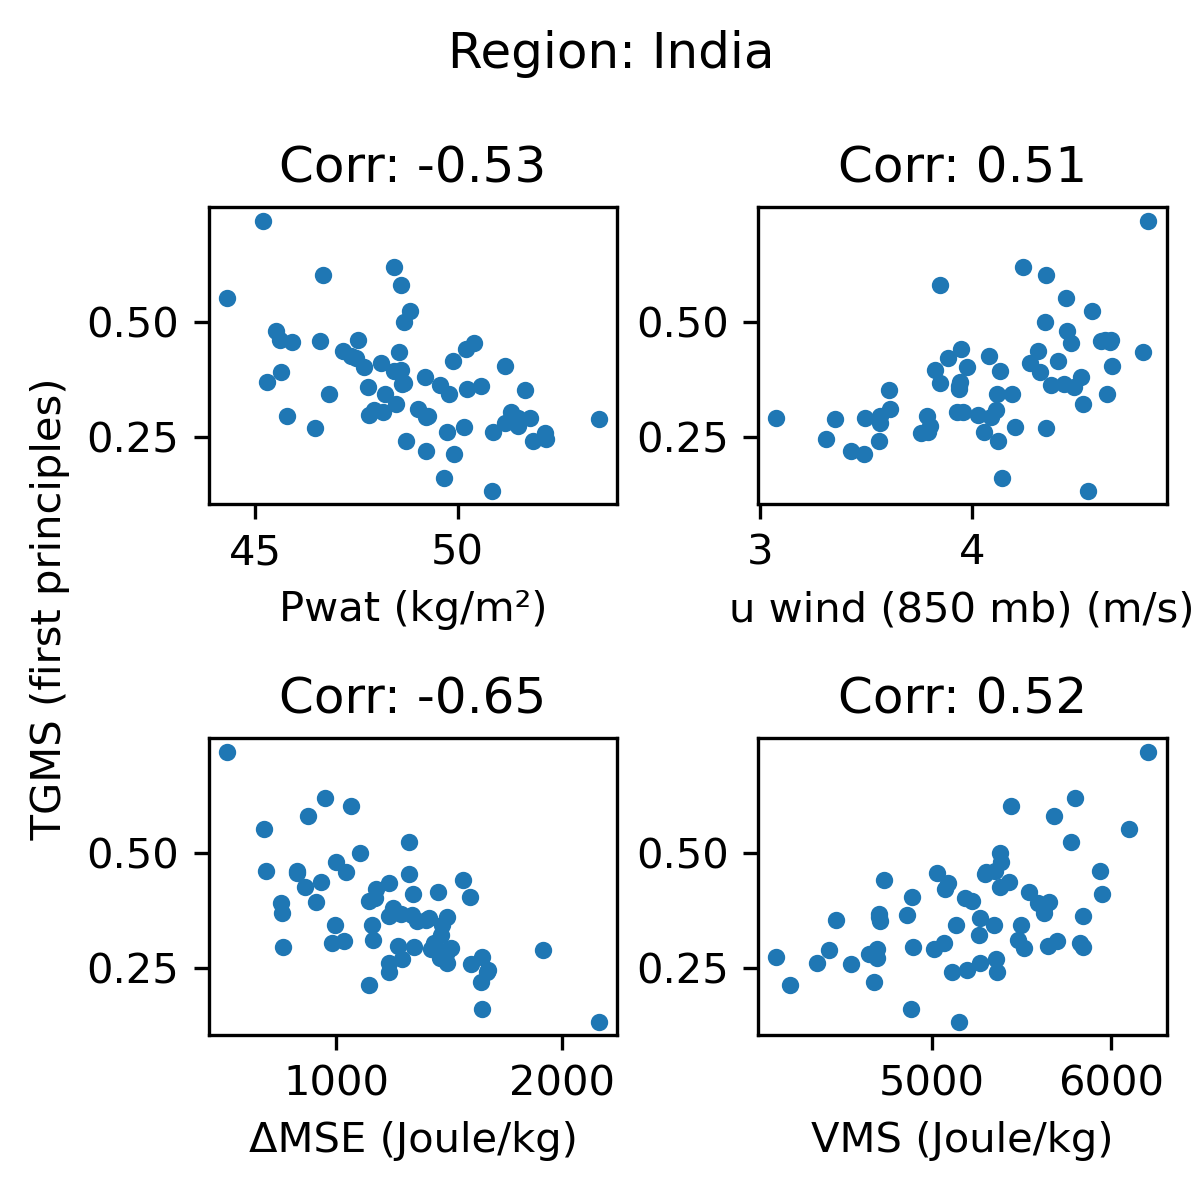

In [73]:
plt.rcParams['figure.figsize'] = [4,4]
corr1 = np.corrcoef(Pwatind, TGMSint)[0][1]
corr2 = np.corrcoef(u850, TGMSint)[0][1]
corr3 = np.corrcoef(delm, TGMSint)[0][1]
corr4 = np.corrcoef(VMS, TGMSint)[0][1]

plt.subplot(2,2,1)
plt.scatter(Pwatind, TGMSint, s=10)
plt.xlabel('Pwat (kg/m\u00b2)')
plt.title('Corr: %.2f' %corr1)


plt.subplot(2,2,2)
plt.scatter(u850, TGMSint, s=10)
plt.xlabel('u wind (850 mb) (m/s)')
plt.title('Corr: %.2f' %corr2)

plt.subplot(2,2,3)
plt.scatter(delm, TGMSint, s=10)
plt.xlabel('\u0394MSE (Joule/kg)')
plt.ylabel('                                          TGMS (first principles)')
plt.title('Corr: %.2f' %corr3)

plt.subplot(2,2,4)
plt.scatter(VMS, TGMSint, s=10)
plt.xlabel('VMS (Joule/kg)')
plt.title('Corr: %.2f' %corr4)

plt.suptitle('Region: India')
plt.tight_layout()

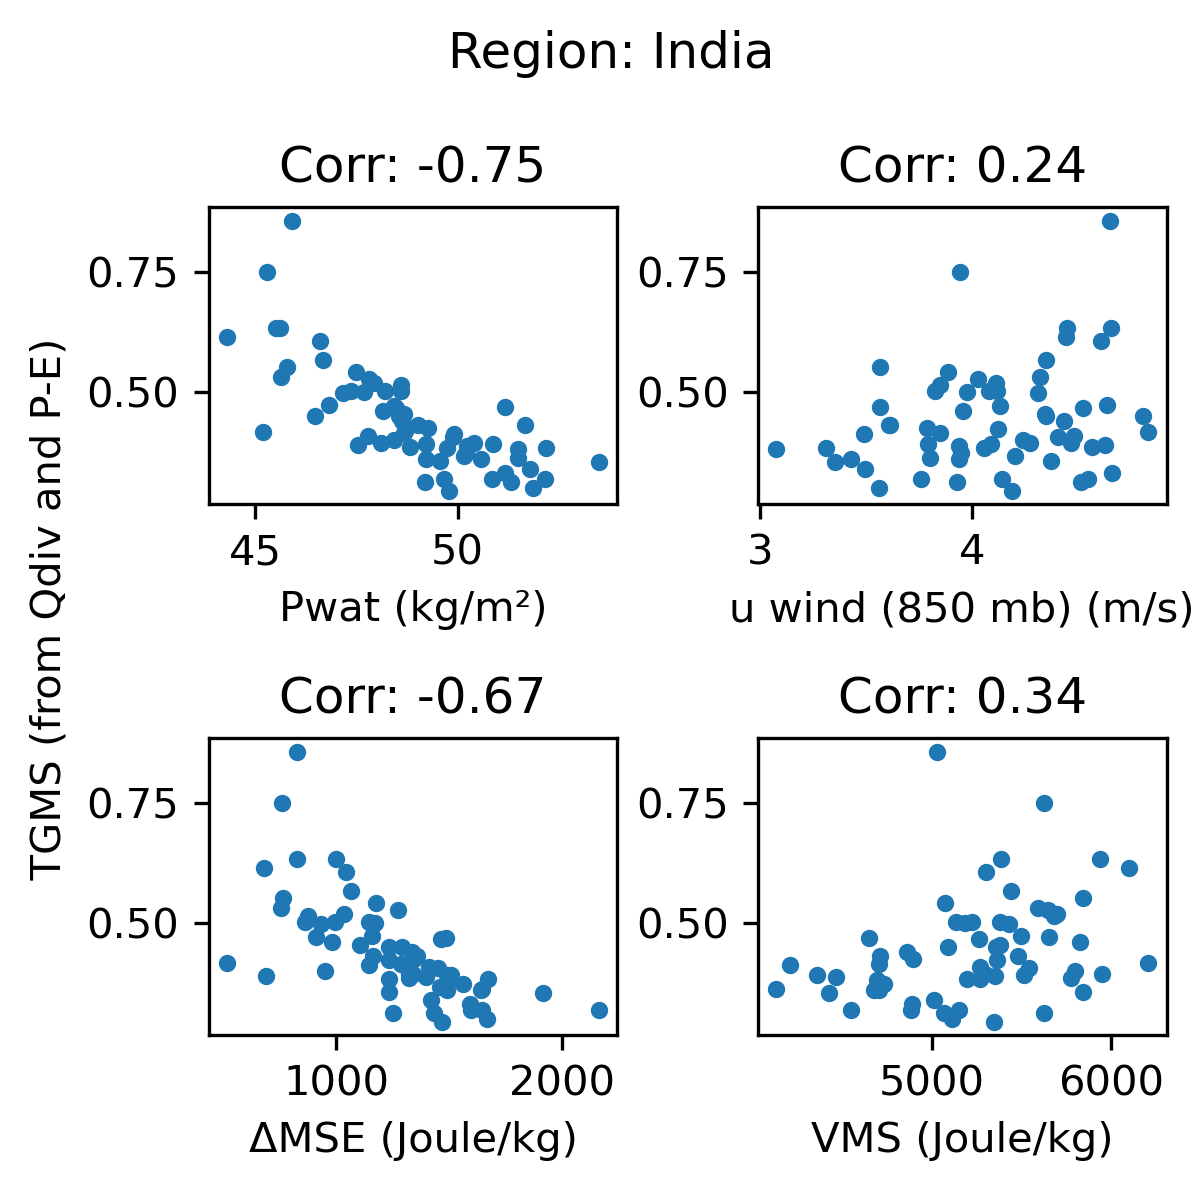

In [74]:
plt.rcParams['figure.figsize'] = [4,4]
corr1 = np.corrcoef(Pwatind, TGMSqdiv)[0][1]
corr2 = np.corrcoef(u850, TGMSqdiv)[0][1]
corr3 = np.corrcoef(delm, TGMSqdiv)[0][1]
corr4 = np.corrcoef(VMS, TGMSqdiv)[0][1]

plt.subplot(2,2,1)
plt.scatter(Pwatind, TGMSqdiv, s=10)
plt.xlabel('Pwat (kg/m\u00b2)')
plt.title('Corr: %.2f' %corr1)


plt.subplot(2,2,2)
plt.scatter(u850, TGMSqdiv, s=10)
plt.xlabel('u wind (850 mb) (m/s)')
plt.title('Corr: %.2f' %corr2)

plt.subplot(2,2,3)
plt.scatter(delm, TGMSqdiv, s=10)
plt.xlabel('\u0394MSE (Joule/kg)')
plt.ylabel('                                          TGMS (from Qdiv and P-E)')
plt.title('Corr: %.2f' %corr3)

plt.subplot(2,2,4)
plt.scatter(VMS, TGMSqdiv, s=10)
plt.xlabel('VMS (Joule/kg)')
plt.title('Corr: %.2f' %corr4)

plt.suptitle('Region: India')
plt.tight_layout()

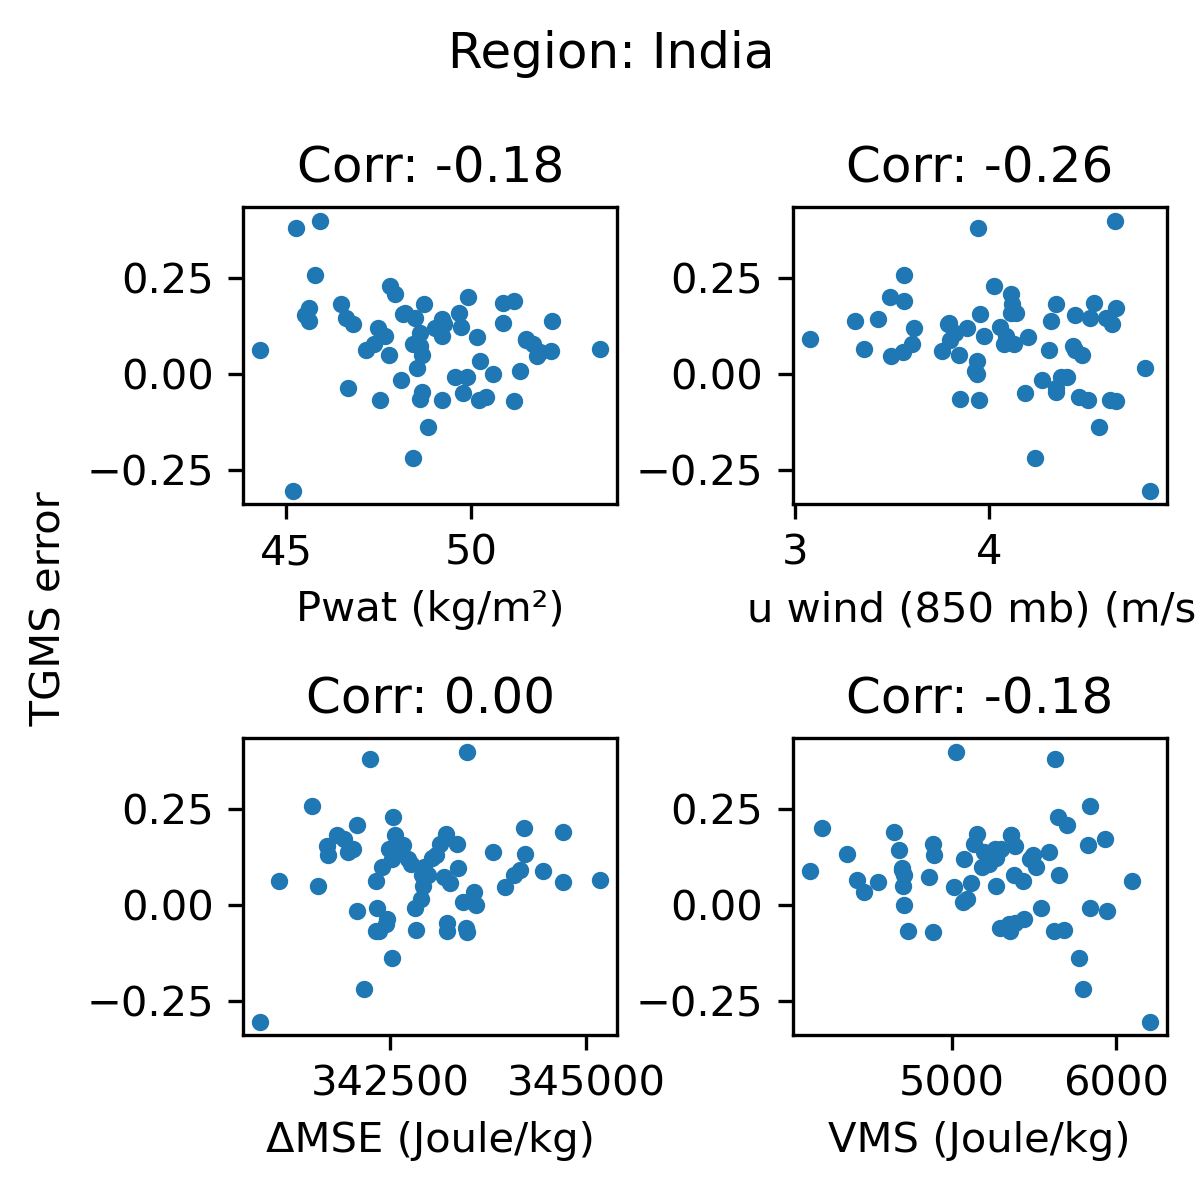

In [75]:
plt.rcParams['figure.figsize'] = [4,4]
corr1 = np.corrcoef(Pwatind, TGMSerror)[0][1]
corr2 = np.corrcoef(u850, TGMSerror)[0][1]
corr3 = np.corrcoef(delm, TGMSerror)[0][1]
corr4 = np.corrcoef(VMS, TGMSerror)[0][1]

plt.subplot(2,2,1)
plt.scatter(Pwatind, TGMSerror, s=10)
plt.xlabel('Pwat (kg/m\u00b2)')
plt.title('Corr: %.2f' %corr1)


plt.subplot(2,2,2)
plt.scatter(u850, TGMSerror, s=10)
plt.xlabel('u wind (850 mb) (m/s)')
plt.title('Corr: %.2f' %corr2)

plt.subplot(2,2,3)
plt.scatter(m850, TGMSerror, s=10)
plt.xlabel('\u0394MSE (Joule/kg)')
plt.ylabel('                                          TGMS error')
plt.title('Corr: %.2f' %corr3)

plt.subplot(2,2,4)
plt.scatter(VMS, TGMSerror, s=10)
plt.xlabel('VMS (Joule/kg)')
plt.title('Corr: %.2f' %corr4)

plt.suptitle('Region: India')
plt.tight_layout()

In [19]:
PE = np.array([5.492755 , 4.624494 , 5.182426 , 4.6577587, 4.786926 , 5.928749 ,
       4.369613 , 4.8077483, 5.479464 , 4.818146 , 3.6604855, 4.9714975,
       4.72429  , 3.118099 , 5.1379194, 3.0729117, 5.190347 , 4.0437474,
       3.3342884, 4.1086087, 2.6172829, 4.4087496, 3.4464169, 2.712718 ,
       4.462042 , 3.8272936, 3.217446 , 3.4523368, 2.2653477, 4.9088635,
       4.4899898, 5.315864 , 3.9012625, 3.2132025, 4.0980773, 4.773147 ,
       3.8354995, 4.4751215, 4.220293 , 4.207741 , 3.8847451, 3.7922602,
       3.7382054, 3.2610838, 5.054839 , 3.625381 , 4.0159926, 4.2998805,
       5.589417 , 5.22165  , 3.6980567, 5.195462 , 5.6193423, 4.583306 ,
       5.468233 , 3.7352583, 3.5709567, 5.2221117, 4.434179 , 4.42724  ,
       5.68412  , 5.236658 , 4.5345   ])

In [20]:
Pwathigh = []
Pwatlow = []
wadvhigh = []
wadvlow = []
hadvhigh = []
hadvlow = []
for i in range(len(PE)):
    if PE[i]>np.average(PE):
        Pwathigh.append(Pwatind[i])
        wadvhigh.append(np.array(wadvind)[i])
        hadvhigh.append(np.array(hadvind)[i])
    else: 
        Pwatlow.append(Pwatind[i])
        wadvlow.append(np.array(wadvind)[i])
        hadvlow.append(np.array(hadvind)[i])

Text(0, 0.5, '<udm/dx+vdm/dy>')

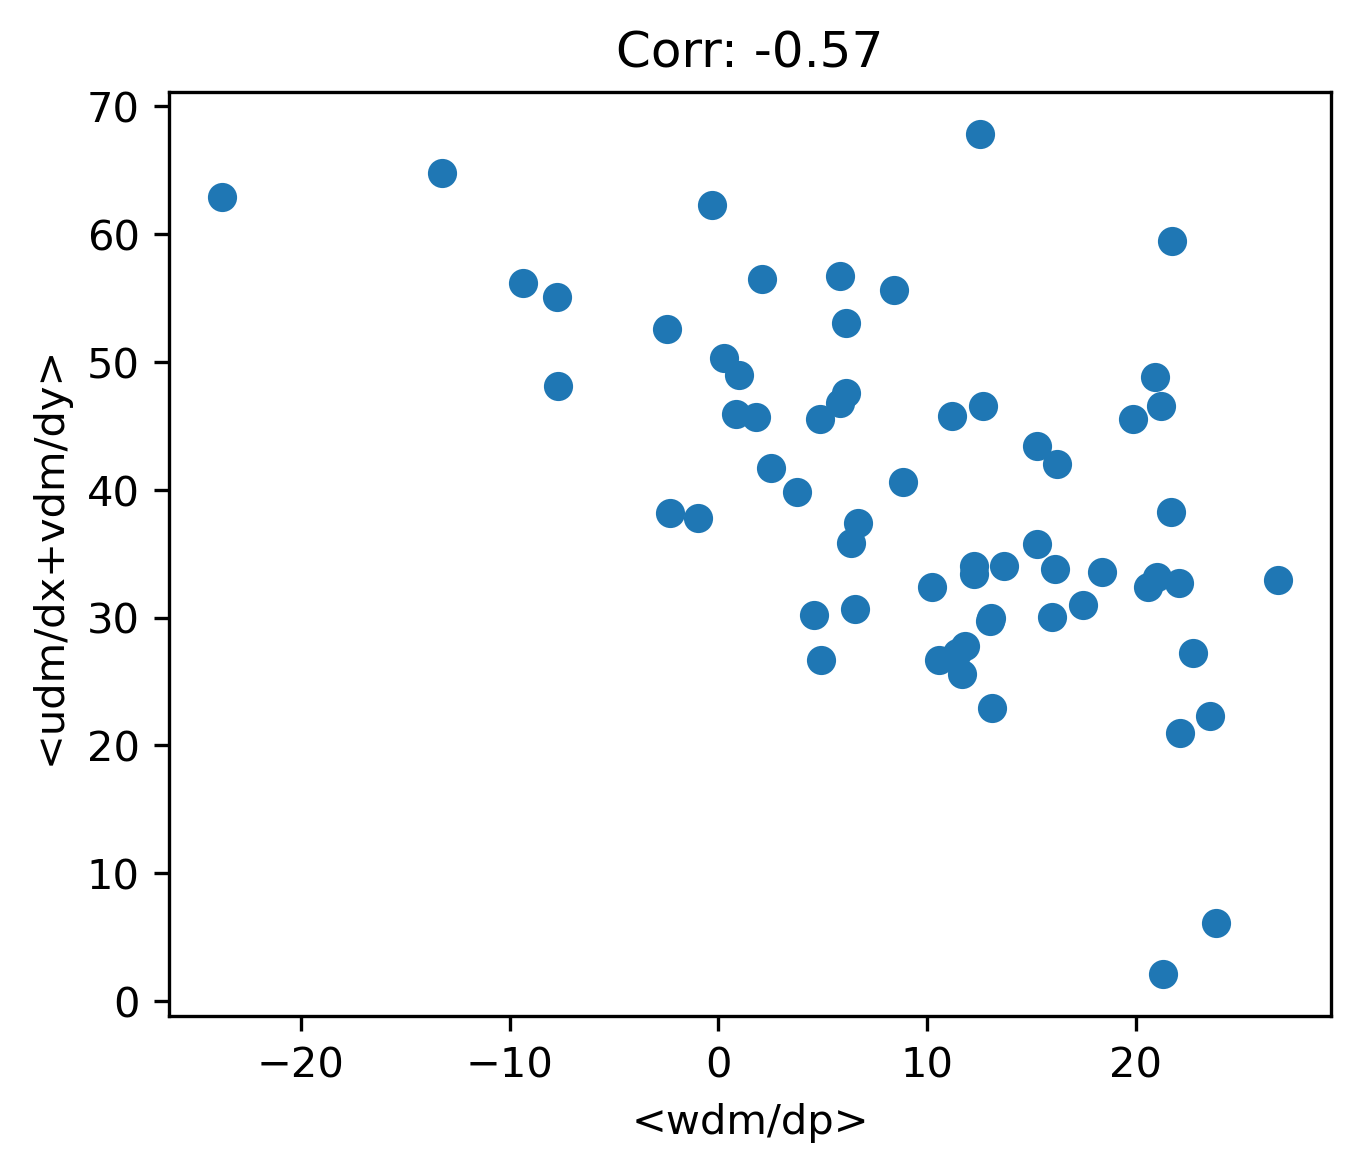

In [108]:
plt.scatter(wadvind, hadvind)
plt.title('Corr: %.2f' %np.corrcoef(wadvind, hadvind)[0][1])
plt.xlabel('<wdm/dp>')
plt.ylabel('<udm/dx+vdm/dy>')

# Decadal stats

In [67]:
k=10 #In your case
decPwat=np.mean(Pwatind[1:61].reshape(-1, k), axis=1)

In [72]:
decdelm=np.mean(np.array(delm)[1:61].reshape(-1, k), axis=1)

In [79]:
decvadv = np.mean(np.multiply(-1, vadvind)[1:61].reshape(-1, k), axis=1)
dechadv = np.mean(np.multiply(-1, hadvind)[1:61].reshape(-1, k), axis=1)

array([[1.        , 0.47334652],
       [0.47334652, 1.        ]])

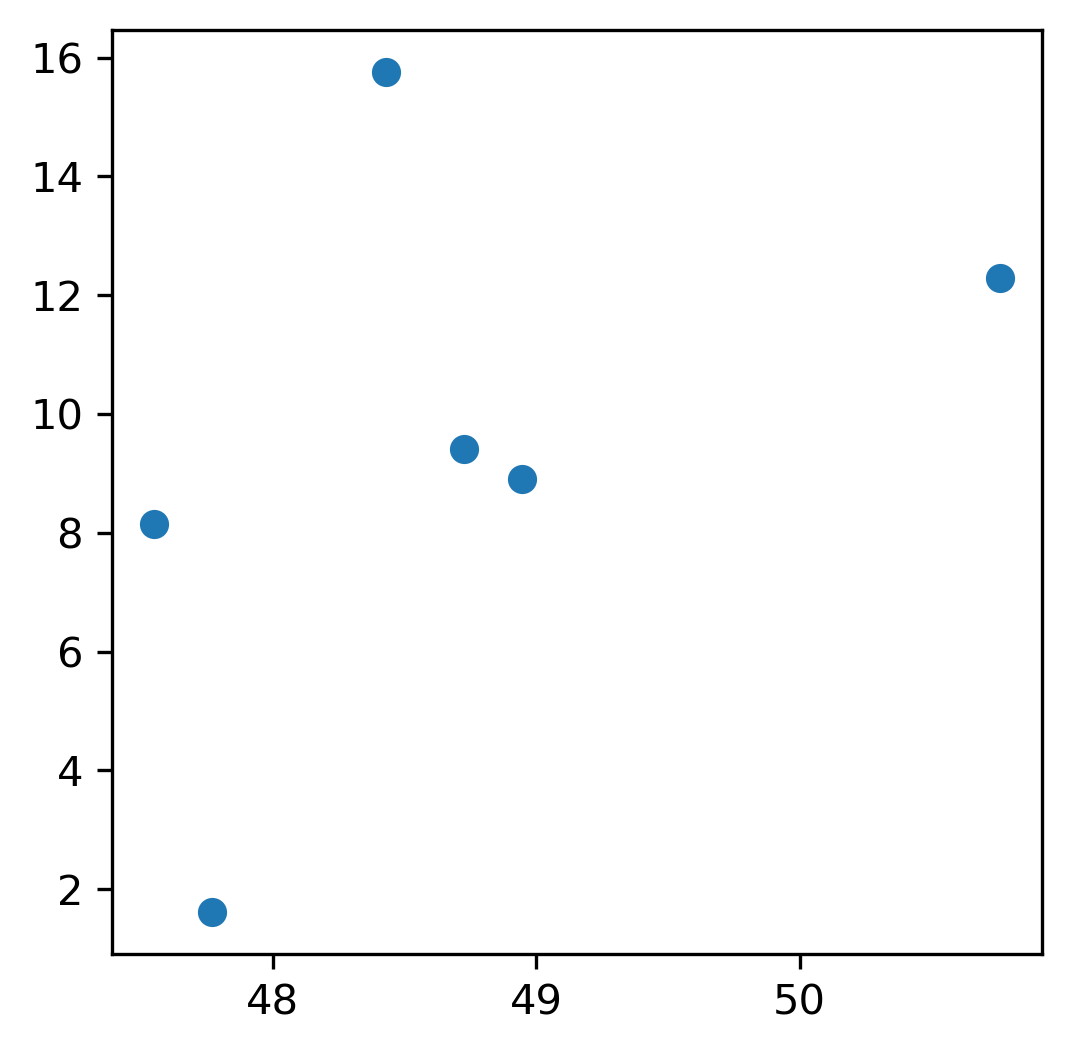

In [76]:
plt.scatter(decPwat, decvadv)
np.corrcoef(decPwat, decvadv)

array([[1.       , 0.6894716],
       [0.6894716, 1.       ]])

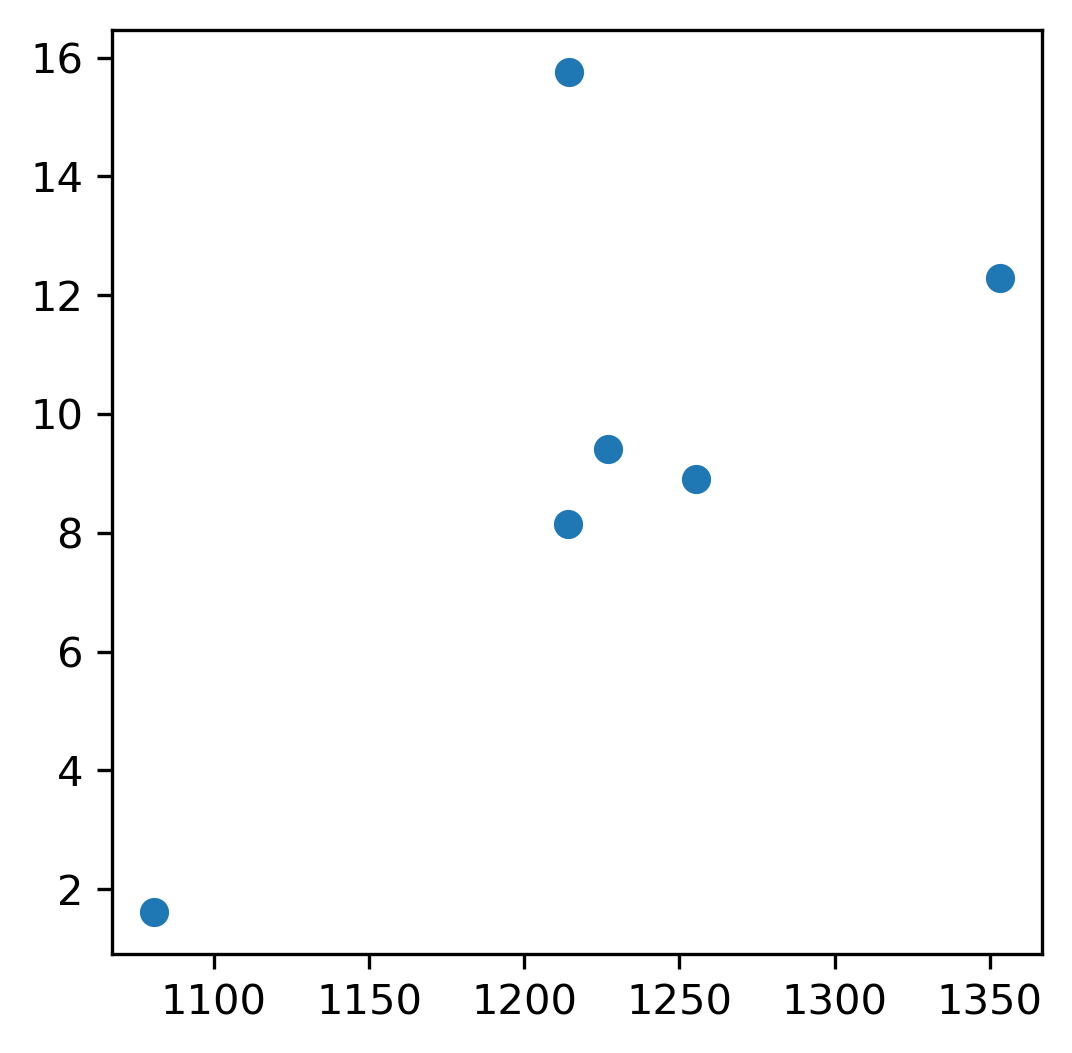

In [78]:
plt.scatter(decdelm, decvadv)
np.corrcoef(decdelm, decvadv)

array([[ 1.        , -0.05953195],
       [-0.05953195,  1.        ]])

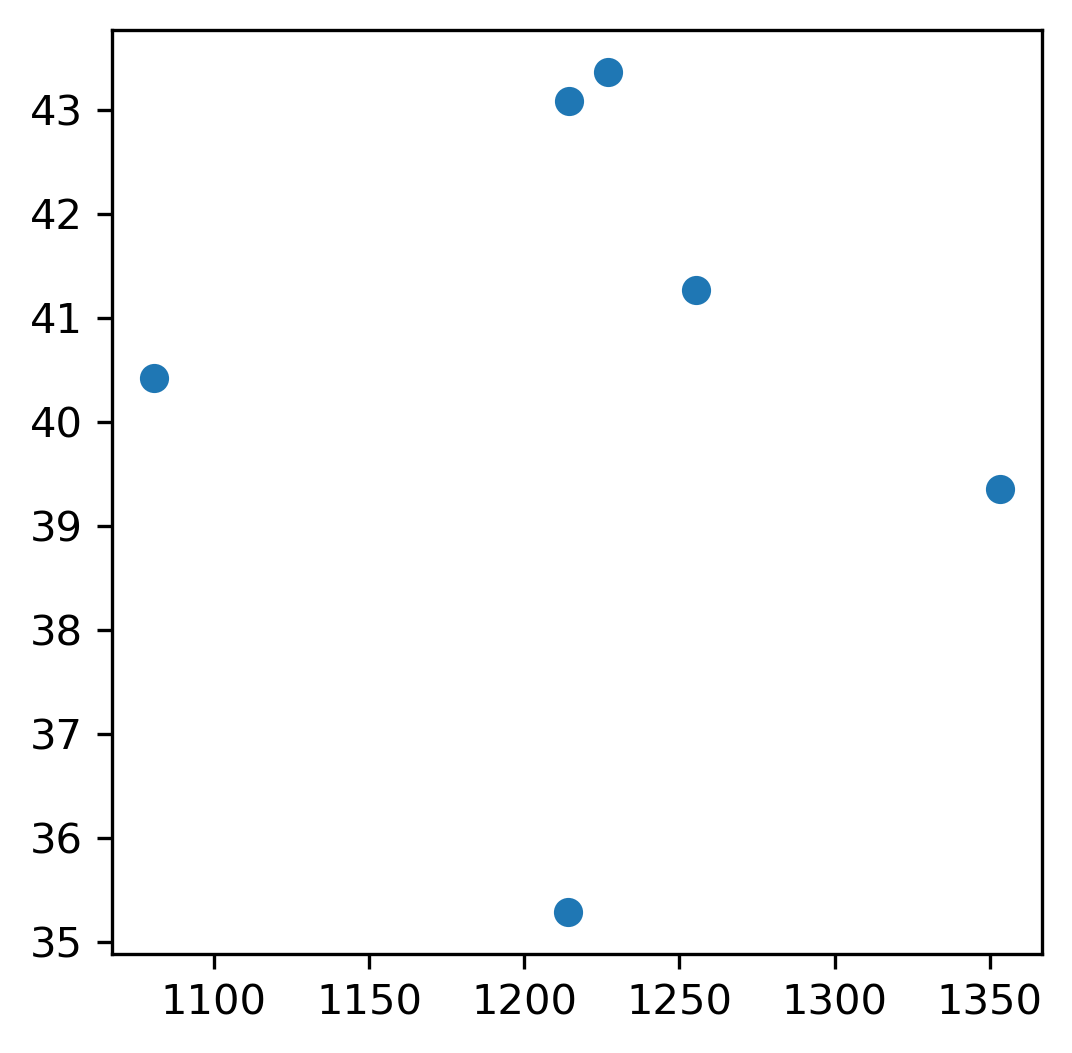

In [81]:
plt.scatter(decdelm, dechadv)
np.corrcoef(decdelm, dechadv)

In [8]:
#Integrating spatial average vs spatially averaging integrals
vadvgrid=[]
vadvavg=[]
x=ds5.level
xs= np.arange(1, 1001, 1)
for j in ds5.year:
    ds6 = ds5.sel(year=j)
    m = Cp*ds6.t + Lv*ds6.q + ds6.z
    vadv = mpcalc.advection(m, w=ds6.w)
    inter = vadv.interp(level=xs, method="cubic")
    vadvgrid.append(np.average(inter.integrate('level'))/g)
    vadv = mpcalc.advection(m, w=ds6.w).mean(dim=['latitude', 'longitude'])
    cs = scipy.interpolate.CubicSpline(x, vadv)
    ys = cs(xs)
    vadvavg.append(scipy.integrate.simpson(ys, xs)/g)

In [9]:
ds5 = ds5.sel(level=slice(100,1000))

In [10]:
vadv100=[]
x=ds5.level
xs= np.arange(100, 1001, 1)
for j in ds5.year:
    ds6 = ds5.sel(year=j)
    m = Cp*ds6.t + Lv*ds6.q + ds6.z
    vadv = mpcalc.advection(m, w=ds6.w)
    inter = vadv.interp(level=xs, method="cubic")
    vadv100.append(np.average(inter.integrate('level'))/g)

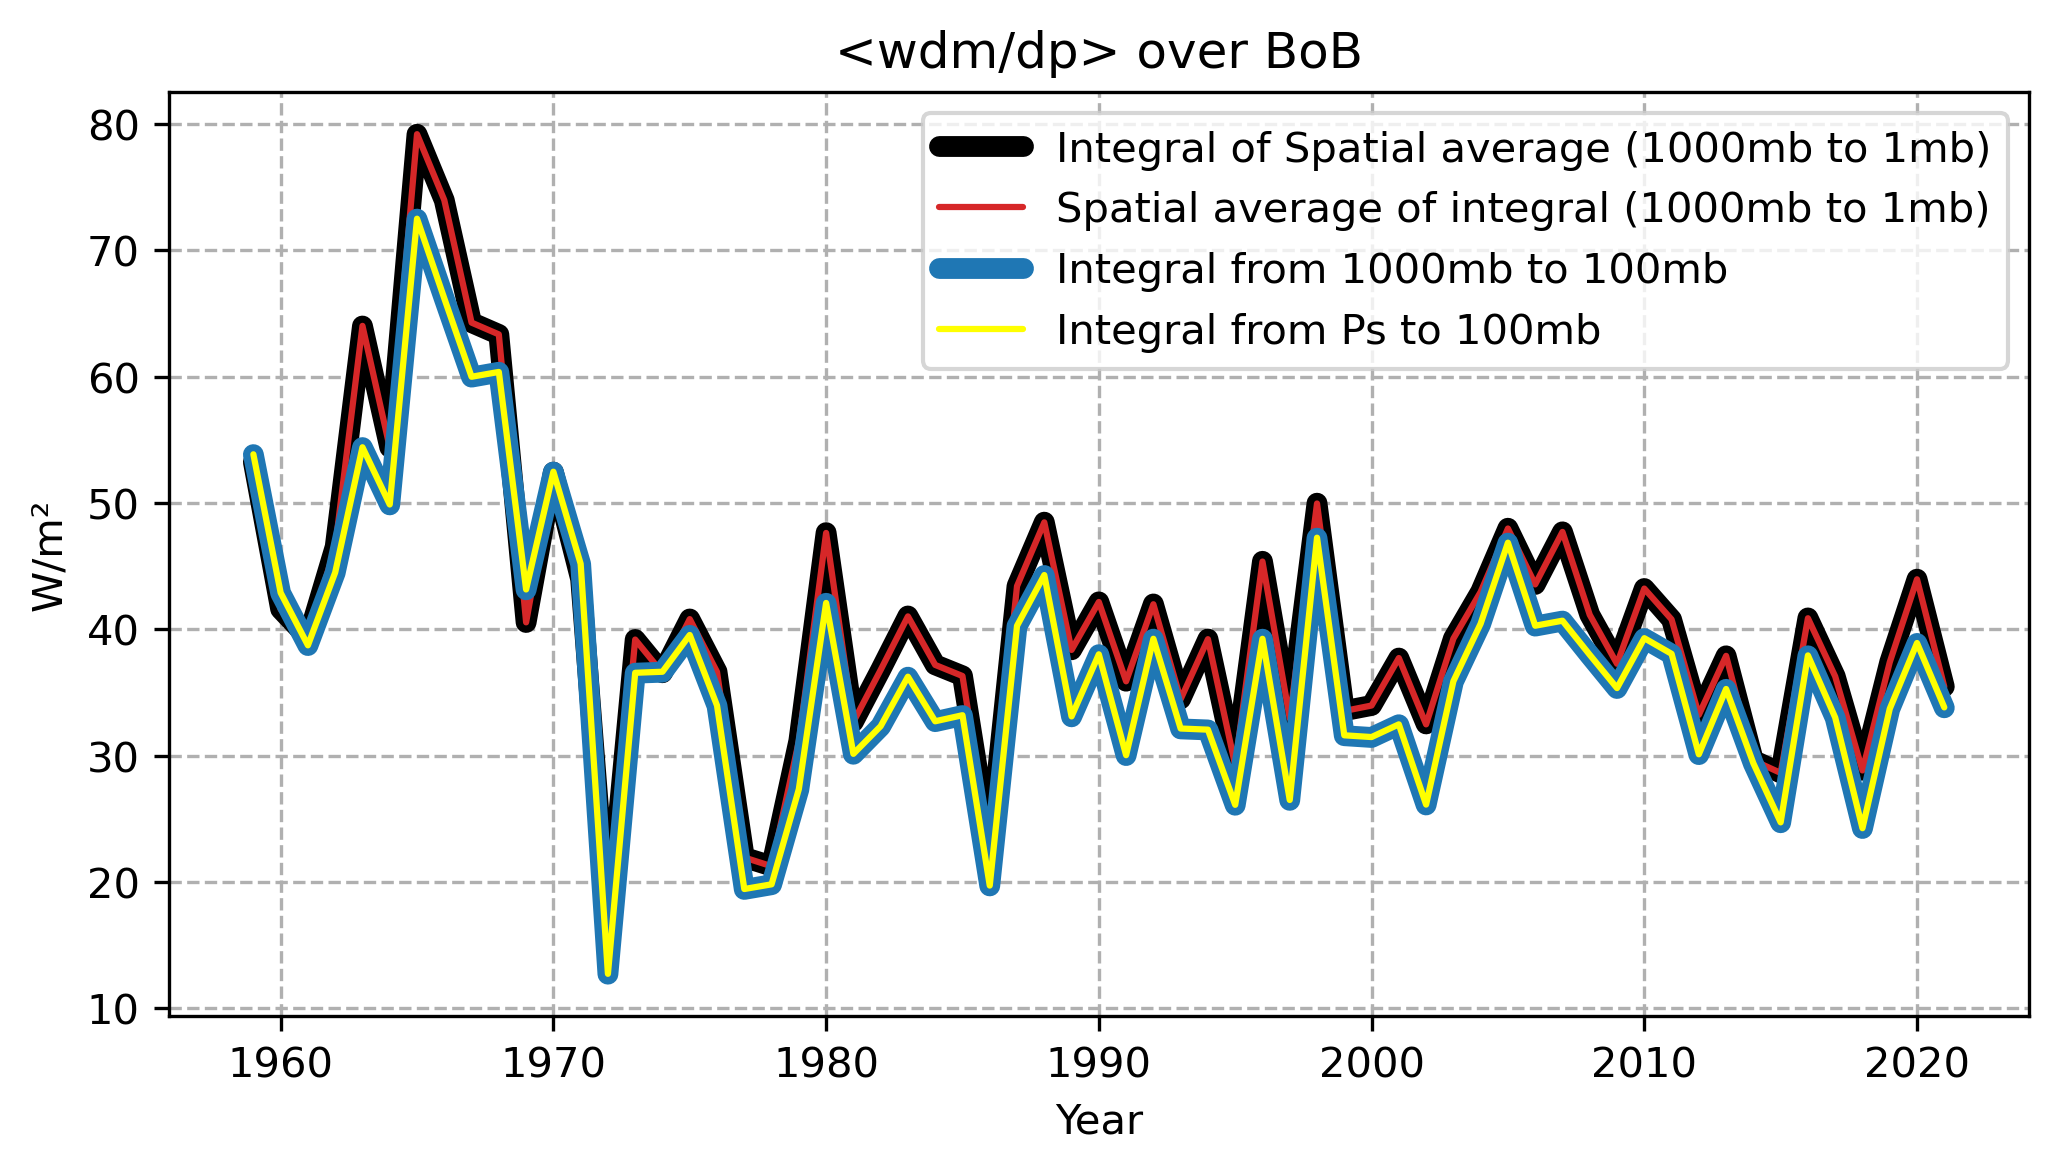

In [17]:
plt.rcParams['figure.figsize'] = [8,4]
plt.plot(ds5.year, np.multiply(-1, vadvavg), c='black', label='Integral of Spatial average (1000mb to 1mb)', lw=5, solid_capstyle='round')
plt.plot(ds5.year, np.multiply(-1, vadvgrid), c='tab:red', label='Spatial average of integral (1000mb to 1mb)', solid_capstyle='round')
plt.plot(ds5.year, np.multiply(-1, vadv100), c='tab:blue', label='Integral from 1000mb to 100mb', lw=5, solid_capstyle='round')
plt.plot(ds5.year, np.multiply(-1, vadvps), c='yellow', label='Integral from Ps to 100mb', solid_capstyle='round')
#plt.plot(ds5.year, np.multiply(-1, vadvps2), c='tab:orange', label='Integral from Ps to 100mb')
plt.xlabel('Year')
plt.ylabel('W/m\u00b2')
plt.legend()
plt.title('<wdm/dp> over BoB')
plt.grid(linestyle='--')